In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from astropy.table import Table
import time
from pandas import DataFrame, read_csv
import pandas as pd 
from mpl_toolkits.mplot3d import Axes3D
import copy
import pickle
import math
from scipy.spatial import KDTree
import time
import matplotlib.path as mpltPath
#from matplotlib.patches import Circle, Wedge, Polygon
import numpy.polynomial.polynomial as poly

In [2]:
file = r'Ophiucius_DR2_2MASS_SDSS.csv'
df = pd.read_csv(file)
df2 = df.columns.get_values()
df2.tolist()
#print('Succesfully Read in the Data')

C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (96) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


['Unnamed: 0',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source'

In [3]:
Gmag = df["phot_g_mean_mag"].values
GBmag = df["phot_bp_mean_mag"].values
GRmag = df["phot_rp_mean_mag"].values
# 2MASS bands
Jmag = df["j_m"].values
Hmag = df["h_m"].values
Kmag = df["ks_m"].values
GK = Gmag - Kmag
# Other Important Data
plx = df["parallax"].values
Dist = 1000./plx
K_unc = df["ks_msigcom"].values
J_unc = df['j_msigcom'].values
H_unc = df['h_msigcom'].values
G_flux = df["phot_g_mean_flux"].values
G_flux_er = df["phot_g_mean_flux_error"].values
GB_flux = df['phot_bp_mean_flux'].values
GB_flux_er = df['phot_bp_mean_flux_error'].values
GR_flux = df['phot_rp_mean_flux'].values
GR_flux_er = df['phot_rp_mean_flux_error'].values
SNR = G_flux/G_flux_er
RA = df["ra"].values
DEC = df["dec"].values
AG = df['a_g_val']

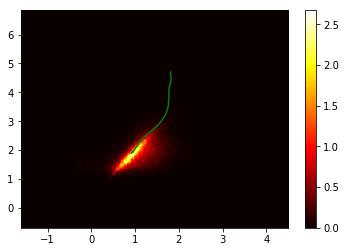

In [67]:
GB_GR = GBmag - GRmag
J_K = Jmag - Kmag

# plt.scatter(J_K,GB_GR,c='k',s=2.0,alpha=0.5,marker='+')
# #plt.show()
# AVarray = np.arange(5,6,1)
# print(AVarray)

# print(len(Temps))
# for i in range(len(AVarray)):
#     currentAV = AVarray[i]
#     currentAV = round(currentAV, 4)
#     colorPlots = np.array(Temps[currentAV]['Colors'])
#     tempGB_GR = colorPlots[:,1] - colorPlots[:,0]
#     tempJ_K = colorPlots[:,4] - colorPlots[:,2]
#     plt.scatter(tempJ_K,tempGB_GR,alpha=0.8,s=1.0)
# # plt.xlim(-0.5,8)
# # plt.ylim(-0.5,2.0)
# plt.show()

# JK = []
# GBGR = []
# for i in range(len(J_K)):
#     if(str(J_K[i]) != 'nan' and str(GB_GR[i]) != 'nan'):
#         JK.append(J_K[i])
#         GBGR.append(GB_GR[i])
    
   
JK = np.array(JK)
GBGR = np.array(GBGR)
heatmap, xedges, yedges = np.histogram2d(JK, GBGR, bins=200,normed=True)
plt.imshow(heatmap.T, origin='lower',aspect='auto',extent=[np.min(JK),np.max(JK),np.min(GBGR),np.max(GBGR)])
plt.set_cmap('hot')
plt.colorbar()

br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1_factor.pickle', 'rb'))
Temps = br['Temps']     

for i in range(len(AVarray)):
    currentAV = AVarray[i]
    currentAV = round(currentAV, 4)
    colorPlots = np.array(Temps[currentAV]['Colors'])
    tempGB_GR = colorPlots[:,1] - colorPlots[:,0]
    tempJ_K = colorPlots[:,4] - colorPlots[:,2]
    plt.plot(tempJ_K,tempGB_GR,alpha=1.0,c='g')

plt.show()


122073 336739
[nan nan nan]


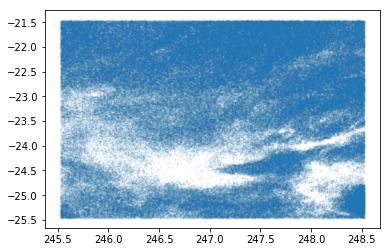

336739


In [28]:
plt.scatter(RA,DEC,s=1.0,alpha=0.05)
plt.show()
print(len(Gmag))

In [4]:
def MagError(flux2,flux2_er,min_val):
    
    #Mag = 2.5*np.log10(flux1/flux2) + KnownMag
    Mag_er = np.sqrt((2.5/np.log(10)**2)*(flux2_er/flux2)**2)
    #Mag_er = np.sqrt(((2.5/(np.log(10)*flux1))*flux1_er)**2 + ((-2.5/(np.log(10)*flux2))*flux2_er)**2)
    if(Mag_er < min_val):
        Mag_er = min_val
    return Mag_er

In [5]:
# FIT FUNCTION USING BOTH STAR MAG UNCERTAINTY AND STANDARD ERROR IN TEMPLATE
def StarFit(starBands,color_mags,starError,color_std_err):
    
    
    if(len(starBands) == 6.0):
        new_starBands = []
        for i in range(len(starBands)):
            if(i == 0):
                G = starBands[i]
            else:
                G_X = G - starBands[i]
                new_starBands.append(G_X)
        new_starBands = np.array(new_starBands)
    else:
        new_starBands = np.array(starBands)

    template_bands = []
    template_err = []
    std_err = []
    for i in range(len(color_mags)):
        cm = color_mags[i,:]
        cm = cm[~np.isnan(cm)]
        cs = color_std_err[i,:]
        cs = cs[~np.isnan(cs)]
        template_bands.append(cm)
        template_err.append(cs)
    template_bands = np.array(template_bands)
    template_err = np.array(template_err)
    
    newStarError = []
    for i in range(len(starError)):
        if(i == 0):
            sigmaG = starError[i]
        else:
            sigma = starError[i]
            newStarError.append(np.sqrt(sigmaG**2+sigma**2))
    newStarError = np.array(newStarError)
    Chi2_vals = []
    
    QuadError = []
    for i in range(len(template_err)):
        QuadError.append(np.sqrt(newStarError**2 + template_err[i]**2))
    QuadError = np.array(QuadError)

    Chi = []
    for i in range(len(template_bands)):
        Chi2 = ((template_bands[i] - new_starBands)**2/(QuadError[i])**2)
        Chi2 = np.sum(Chi2)
        
#         for j in range(len(new_starBands)):
#             Chi2 = Chi2 + ((template_bands[i,j] - new_starBands[j])**2/(QuadError[i,j])**2)
        Chi2 = Chi2/(len(new_starBands))  # EDITED THIS LINE JUNE 7TH. GOT RID OF THE -1
        Chi2_vals.append(Chi2)
    
    Chi2_vals = np.array(Chi2_vals)
   
    red_Chi2 = []
    for i in range(len(Chi2_vals)):
        if(Chi2_vals[i] == np.min(Chi2_vals)):
            chi = Chi2_vals[i]
            
            best_fit = i
            #GK_val = spec
            val = GK_int[best_fit]
            #GK_val = val #G_K_int[index]
            quad = QuadError[i]
    return best_fit, chi, val, Chi2_vals, quad

In [6]:
def distance_map(data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour):
    #Function uses KD Tree to create a distance map and returns pixel counts along both axes, as well as the
    #scale of degrees to pixel for each axis
    
    #Variables Read In
    #data: an array with two columns of stellar coordinates (RA,DEC)
    #pixel_count: number of pixels for large side of image
    #RAmin, RAmax, DEmin, DEmax: min/max coordinates of image
    #neighbor: number of nearest neighbor to calculate
    #scatter: True/False create a scatter plot of the stars
    #contour: True/False create a contour plot of the distance map
    
    #Varables Returned
    #dist2: distance map
    #pixel_count: pixel count along x axis
    #pixel_count2: pixel count along y axis
    #dRA: degrees to pixel scale along x axis (for RA)
    #dDE: degrees to pixel scale along y axis (for Dec)

    from scipy.spatial import KDTree

    #use KD tree to find distances to nearest neighbor stars
    tree = KDTree(data)
    
    #find distances between min/max RA and DE
    diffRA = (RAmax - RAmin)
    diffDE = (DEmax - DEmin)
    
    #make pixel count along x and y axes equal initially
    pixel_count2 = pixel_count
    
    #makes sure that both x and y axes have same scale of degrees to pixel
    if (diffRA < diffDE):
        dDE = diffDE/pixel_count2
        pixel_count = int(diffRA/dDE)
        dRA = diffRA/pixel_count
    if (diffRA > diffDE):
        dRA = diffRA/pixel_count
        pixel_count2 = int(diffDE/dRA)
        dDE = diffDE/pixel_count2
    if (diffRA == diffDE):
        dRA = diffRA/pixel_count
        dDE = diffDE/pixel_count
        
    #create array of coordinates for image background
    for i in range(0,pixel_count):
        for j in range(0,pixel_count2):
            if (i==0 and j == 0):
                array4 = np.array([RAmin,DEmin])
            else:
                array3 = [RAmin+i*dRA,DEmin+j*dDE]
                array4 = np.vstack((array4,array3))

    #find nearest neighbor distances to background points
    image = tree.query(array4,k=neighbor+1)

    #change array of background points so it is pixel_count x pixel_count2
    dist2 = image[0][:,neighbor-1]
    dist2 = np.resize(dist2,(pixel_count,pixel_count2))
    dist2 = np.rot90(dist2, k=1, axes=(1,0))
    dist2 = np.fliplr(dist2)

    #display map   
    plt.imshow(dist2, origin='lower',extent=[RAmin,RAmax,DEmin,DEmax])
    plt.gca().invert_xaxis()
    plt.show()
    
    #contour plot
    if (contour == True):
        ct = plt.contourf(dist2, cmap='tab10',extent=[RAmin,RAmax,DEmin,DEmax])
        plt.gca().invert_xaxis()
        plt.colorbar()
        plt.show()
    #scatter plot
    if (scatter == True):
        plt.scatter(data[:,0],data[:,1],s = 1,c = 'k')
        plt.gca().invert_xaxis()
        plt.show()
        
    return dist2, pixel_count, pixel_count2, dRA, dDE

In [7]:
def StarSelection(RA,DEC,distArray,L,Gmag,GBmag,GRmag,GaiaFluxes,GaiaFluxes_er,\
                  Tmass,Tmass_er,AG,SNR,Gvalue=999,specRA=999,specDEC=999):
    
    # ***9 Parameters***
    
    # *1st Parameter* "RA"       :  Array of data containing the RA values for the stars in the region
    # *2nd Parameter* "DEC"      :  Array of data containing the DEC values for the stars in the region
    # *3rd Parameter* "Source"   :  Array of data containing the GAIA ID for each star within the region
    # *4th Parameter* "distArray":  Distance Array created by the distance_map function
    # *5th Parameter* "L"        :  Input the contour level you wish to analyze.
    # *6th Parameter* "Gmag"     :  Array of G Magnitude Values
    # *7th Parameter* "Gvalue    :  Reduces data to all stars with this Gmag value or lower. (Optional) 
    # *8th Parameter* "specRA"   :  Specific RA location (Optional)
    # *9th Parameter* "specDEC"  :  Specific DEC location (Optional)
    
    # Outputs a matrix containing all stars located in the desired contour or contour level. The matrix
    # will contain the Star RA, DEC, and ID respectively. However, the function will output Star ID,
    # RA, and DEC respectively
    
    # You can get the contour level by looking at the colorbar next to contour plot
    
    # specRA and specDEC are optional parameters. If no RA and DEC are chosen, you will find
    # all stars within the L contour level. If an RA and DEC are chosen, function will
    # grab stars located in a single contour at the L level. Please specify a RA and DEC by
    # following this syntax: "specRA=100.0" , "specDEC=9.0" (100 and 9 are random values)
    
    # Gvalue is also an optional parameter. If you do not input a Gvalue, the data will not be
    # reduced to a maximum G mag value. If you desire to input a Gvalue, specify the value
    # by following this syntax: "Gvalue=17.0" (Where 17.0 is a random Mag value)
    
    # Reduces Star Data based off of user inputted G Mag value
    data = np.array([RA,DEC])
    if(Gvalue != 999):
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= Gvalue):
                redData.append([RA[i],DEC[i],Gmag[i],GBmag[i],GRmag[i],Tmass[i,0],Tmass[i,1],Tmass[i,2],GaiaFluxes[i,0],\
                                GaiaFluxes[i,1],GaiaFluxes[i,2],GaiaFluxes_er[i,0],GaiaFluxes_er[i,1],GaiaFluxes_er[i,2],\
                                Tmass_er[i,0],Tmass_er[i,1],Tmass_er[i,2],AG[i],SNR[i]])       
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    else:
        max_Gvalue = np.max(Gmag)
        redData = []            
        for i in range(len(Gmag)):
            if(Gmag[i] <= max_Gvalue):
                redData.append([RA[i],DEC[i],Gmag[i],GBmag[i],GRmag[i],Tmass[i,0],Tmass[i,1],Tmass[i,2],GaiaFluxes[i,0],\
                                GaiaFluxes[i,1],GaiaFluxes[i,2],GaiaFluxes_er[i,0],GaiaFluxes_er[i,1],GaiaFluxes_er[i,2],\
                                Tmass_er[i,0],Tmass_er[i,1],Tmass_er[i,2],AG[i],SNR[i]])       

        
        redData = np.array(redData) # Will use redData as the stars to be selected within contours
    
    Ysize, Xsize = np.shape(distArray) # Calculates X and Y size of distance_map Matrix
    
    
    xgrid = np.linspace(np.min(RA),np.max(RA),Xsize) # Creates grid length in X dir
    ygrid = np.linspace(np.min(DEC),np.max(DEC),Ysize) # Creates grid length in Y dir
    X, Y = np.meshgrid(xgrid,ygrid) # Defines Grid
    X = np.array(X)
    Y = np.array(Y)
    if(specRA != 999 and specDEC != 999):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(14,6)
        ax2.set_facecolor('black')
        ax2.invert_xaxis()
        ax2.contour(X,Y,distances[0])
    else:
        fig, ax1 = plt.subplots()
        fig.set_size_inches(7,6)
    ax1.set_facecolor('black')
    cs = ax1.contour(X,Y,distArray,alpha=1.0)
    levels = (len(cs.collections)-1) # Indicates how many levels are on contour plot
    fig.colorbar(cs, ax=ax1)
    ax1.set_xlim([np.min(X),np.max(X)])
    ax1.set_ylim([np.min(Y),np.max(Y)])
    ax1.invert_xaxis()
    
    firstContour = []
    higherContour = []
    insideStars = []
    starCount = 0
    ## The following code will run if user inputs a specifc RA and DEC
    if(specRA != 999 and specDEC != 999):
        G_alpha = 0.6
        size = 5.0
        inside = []
        finalPoly = []
        # get_paths finds every array that contains the (X,Y) points which define each contour at Level L
        for i in range(len(cs.collections[L].get_paths())): # Iterate over each specific array
            p = cs.collections[L].get_paths()[i] # p defines one of these arrays
            v = p.vertices # v contains all (X,Y) points
            x = v[:,0]
            y = v[:,1]
            # If the current array in the loop contains the specific RA and DEC coordinate that the user 
            # inputs, this code will initiate.
            if(specRA >= np.min(x) and specRA <= np.max(x) and specDEC >= np.min(y) and specDEC <= np.max(y)):
                
                ax1.axvline(x=specRA,linestyle='--',color='y',alpha=0.4) # If RA/DEC are inputted, this will plot
                ax1.axhline(y=specDEC,linestyle='--',color='y',alpha=0.4) # a "target" at the coordinate
                ax1.plot(x,y,c='w')
                ax2.plot(x,y,c='w')
                ax2.set_xlim([np.min(x),np.max(x)])
                ax2.set_ylim([np.min(y),np.max(y)])
                ax2.invert_xaxis()
                polygon = v # Creates a Polygon Region from all (X,Y) points in current array
                path = mpltPath.Path(polygon,closed=True) # Creates a path defined by polygon
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]])) # *EDITED CODE* Selects all stars located inside path region
                # Inside Array will be a boolean array (True,False). Any star located inside path will
                # have a value of "True"
                finalPoly = [x,y] # Defines the Polygon that contained user inputed RA/DEC
                
                for s in range(len(inside)):
                    if(inside[s] == True): # Find all stars with an associated "True value"
                        firstContour.append(redData[s]) 
    
        # Next, function needs to recognize any higher level contour contained within itself
        finalPoly = np.transpose(np.array(finalPoly)) # Sets proper dimensions
        inside_higher = [] # Will represent stars within a higher level contour 
        if(L != levels):  # Function will only find a higher contour if L is not the highest already
            for j in range(len(cs.collections[L+1].get_paths())): # All arrays located at L+1 level
                p = cs.collections[L+1].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                # If current array in loop is inside of the L contour, this code will initiate

                if(len(firstContour) > 0 and np.min(x)>=np.min(finalPoly[:,0]) and np.max(x)<=np.max(finalPoly[:,0]) and np.min(y)>=np.min(finalPoly[:,1]) and np.max(y)<=np.max(finalPoly[:,1])):
                    polygon = v
                    path2 = mpltPath.Path(polygon,closed=True) # defines path of higher level contour
                    inside_higher = path2.contains_points(np.transpose([redData[:,0],redData[:,1]])) #EDITED CODE finds all stars inside higher contour
                    for s in range(len(inside_higher)):
                        if(inside_higher[s] == True): # find all stars with an associated "True" vale
                            higherContour.append(redData[s])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour) # Defines two arrays that have the same length as the 
        # data.  
        
        # The for loop will find all stars that are within the lower contour "firstContour" and outside
        # of the higher contour "higherContour". All stars that match these conditions will be added to
        # insideStars. 
        for s in range(len(firstContour)):
            if(len(higherContour > 0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                #if(firstContour[s,2] not in higherContour[:,2]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])

        insideStars = np.array(insideStars)
        
    ## The following code will run if user does not specify a RA or DEC
    # The code is almost the exact same as above with a few differences.
    else:
        firstContour = []
        higherContour = []
        inside = []
        for j in range(len(cs.collections[L].get_paths())):
                p = cs.collections[L].get_paths()[j]
                v = p.vertices
                x = v[:,0]
                y = v[:,1]
                polygon = v
                path = mpltPath.Path(polygon,closed=False)
                inside = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
                # Collects all stars in all contours, not dependent on the location of contour.
                for i in range(len(inside)):
                    if(inside[i] == True):
                        #starCount = starCount + 1
                        firstContour.append(redData[i])
                if(len(firstContour) > 0): 
                    ax1.plot(x,y,c='w',alpha=1.0,lw=0.7)
        if(L != levels):
            for j in range(len(cs.collections[L+1].get_paths())):
                p = cs.collections[L+1].get_paths()[j]
                v = p.vertices
                polygon = v 
                path = mpltPath.Path(polygon,closed=False)
                inside_higher = path.contains_points(np.transpose([redData[:,0],redData[:,1]]))
                for i in range(len(inside_higher)):
                        if(inside_higher[i] == True):
                            starCount = starCount + 1
                            higherContour.append(redData[i])
        higherContour = np.array(higherContour)
        firstContour = np.array(firstContour)
        for s in range(len(firstContour)):
            if(len(higherContour >0)):
                if(firstContour[s,0] not in higherContour[:,0] and firstContour[s,1] not in higherContour[:,1]):
                    insideStars.append(firstContour[s])
            else:
                insideStars.append(firstContour[s])
        insideStars = np.array(insideStars)
    
    if(Gvalue != 999):
        print('Gmag <= ',Gvalue,'\nTotal Stars: ',len(redData))
    else:
        print('No cut-off Gmag value \nTotal Stars: ',len(redData))
    
    #ax1.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',alpha=G_alpha,marker='*')
    #if(specRA != 999 and specDEC != 999):
        #ax2.scatter(redData[:,0],redData[:,1],s=0.3,c='orange',marker='*')
    
    # The following code specifies what is plotted for each case, and the title's associated 
    # with each plot
    if(len(insideStars) > 0):
        ax1.scatter(insideStars[:,0],insideStars[:,1],s=1.0,c='r',marker='*')
        if(specRA != 999 and specDEC != 999):
            ax2.scatter(insideStars[:,0],insideStars[:,1],s=15.0,c='r',marker='*')
            ax1.set_title('Plot of Stars Located in Specific Contour')
            ax2.set_title('Magnified Image of Chosen Contour')
            ax2.set_xlabel('RA')
            ax2.set_ylabel('DEC')

        else:
            ax1.set_title('Plot of Stars Located in Chosen Contour Level')
        ax1.set_xlabel('RA')
        ax1.set_ylabel('DEC')
        plt.show()
        print('Total Stars within contour: ',len(insideStars),'\n\n')
        print('Order of data within star array:\n')
        print('[RA[i],DEC[i],Gmag[i],GBmag[i],GRmag[i],Tmass[i,0],Tmass[i,1],Tmass[i,2],GaiaFluxes[i,0],GaiaFluxes[i,1],...')
        print('GaiaFluxes[i,2],GaiaFluxes_er[i,0],GaiaFluxes_er[i,1],GaiaFluxes_er[i,2],...')
        print('Tmass_er[i,0],Tmass_er[i,1],Tmass_er[i,2],AG[i],SNR[i]]')
#         print('RA                             DEC\n')
#         for i in range(len(insideStars)):
#             print(insideStars[i,0],'            ',insideStars[i,1])
    else:
        print('No Stars Found')
        plt.show()
   
    return insideStars

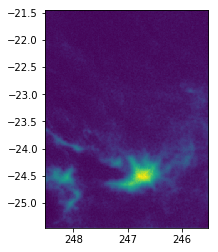

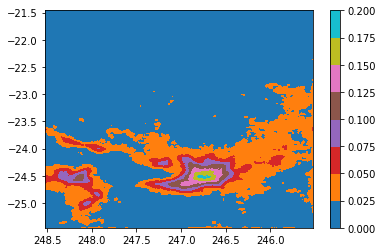

Elapsed time is: 60.69164514541626


In [8]:
import time

num = len(RA)
X1 = np.zeros(num)
Y1 = np.zeros(num)
for i in range(0,num):
    X1[i] = RA[i]
    Y1[i] = DEC[i]
X = np.column_stack((X1,Y1))

RAmin = min(RA)
RAmax = max(RA)
DEmin = min(DEC)
DEmax = max(DEC)
RA_range = RAmax - RAmin
DE_range = DEmax - DEmin
area = RA_range*DE_range
num = len(RA)
density = num/area
start_time = time.time()
    
#range of coordinates
pixel_count = 350
image = False
scatter = False
contour = True
neighbor = 25
# data,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour
distances = distance_map(X,pixel_count,RAmin, RAmax, DEmin, DEmax, neighbor,scatter, contour)
num = time.time() - start_time
print('Elapsed time is: ' + str(num))


122073 336739
[nan nan nan]
No cut-off Gmag value 
Total Stars:  336739


C:\Users\Kevin.Hall\Anaconda3\lib\site-packages\ipykernel_launcher.py:181: RuntimeWarning: invalid value encountered in greater


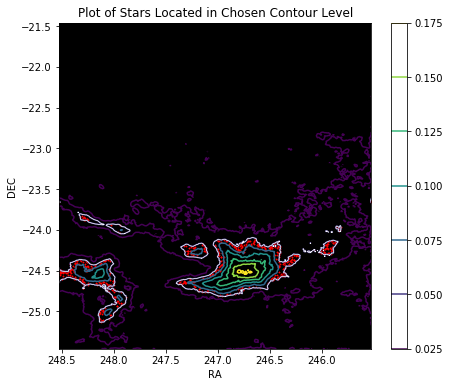

Total Stars within contour:  580 


Order of data within star array:

[RA[i],DEC[i],Gmag[i],GBmag[i],GRmag[i],Tmass[i,0],Tmass[i,1],Tmass[i,2],GaiaFluxes[i,0],GaiaFluxes[i,1],...
GaiaFluxes[i,2],GaiaFluxes_er[i,0],GaiaFluxes_er[i,1],GaiaFluxes_er[i,2],...
Tmass_er[i,0],Tmass_er[i,1],Tmass_er[i,2],AG[i],SNR[i]]


In [10]:
#def StarSelection(RA,DEC,distArray,L,Gmag,GBmag,GRmag,GaiaFLuxes,GaiaFluxes_er,Tmass,Tmass_err,Gvalue=999,specRA=999,specDEC=999):

Tmass = np.transpose([Jmag,Hmag,Kmag])
Tmass_er = np.transpose([J_unc,H_unc,K_unc])
count = 0
for i in range(len(Tmass)):
    T = Tmass[i]
    T = T[~np.isnan(T)]
    if(len(T) == len(Tmass[i])):
        count = count + 1
print(count,len(Gmag))
print(Tmass[4])

GaiaFluxes = np.transpose([G_flux,GB_flux,GR_flux])
GaiaFluxes_er = np.transpose([G_flux_er,GB_flux_er,GR_flux_er])

stars = StarSelection(RA,DEC,distances[0],1,Gmag,GBmag,GRmag,GaiaFluxes,GaiaFluxes_er,Tmass,Tmass_er,AG,SNR)

In [101]:
print((cornerBands[0]))

[-0.55171   0.868907       nan       nan       nan]


In [10]:


dic_AF = pickle.load( open( "AF_4.1_table.pickle", "rb" ) )     
AV_list = dic_AF['Av']
GK_int = dic_AF['G_K_int']

In [93]:
starGaiaFluxs = []
starGaiaFlux_ers = []
noAGstarGaiaFluxs = []
noAGstarGaiaFlux_ers = []
TmassErrors = []
noAGTmassErrors = []
GaiaExt = []
AG_SNR = []
noAG_SNR = []
#print(stars[0])
RelBands = []
noAG_bands = []
nanAG = []
for i in range(len(stars)):
    if(str(stars[i,17]) != 'nan'):
        band = []
        ag = []
        for j in range(2,8):
            if(j == 2):
                G = stars[i,j]
            else:
                band.append(G - stars[i,j])
                ag.append(stars[i,17])
        RelBands.append(band)
        GaiaExt.append(stars[i,17])
        AG_SNR.append(stars[i,18])
        gaiaFlux = []
        gaiaFlux_err = []
        Tmass_err = []
        for j in range(8,11):
            gaiaFlux.append(stars[i,j])
        starGaiaFluxs.append(gaiaFlux)
        for j in range(11,14):
            gaiaFlux_err.append(stars[i,j])
        starGaiaFlux_ers.append(gaiaFlux_err)
        for j in range(14,len(stars[i])-2):
            Tmass_err.append(stars[i,j])
        TmassErrors.append(Tmass_err)
        #print(i)
    else:
        band = []
        ag = []
        for j in range(2,8):
            if(j == 2):
                G = stars[i,j]
            else:
                band.append(G - stars[i,j])
                ag.append(stars[i,17])
        noAG_bands.append(band)
        nanAG.append(stars[i,17])
        gaiaFlux = []
        gaiaFlux_err = []
        Tmass_err = []
        for j in range(8,11):
            gaiaFlux.append(stars[i,j])
        noAGstarGaiaFluxs.append(gaiaFlux)
        for j in range(11,14):
            gaiaFlux_err.append(stars[i,j])
        noAGstarGaiaFlux_ers.append(gaiaFlux_err)
        for j in range(14,len(stars[i])-2):
            Tmass_err.append(stars[i,j])
        noAGTmassErrors.append(Tmass_err)
        noAG_SNR.append(stars[i,17])
noAG_bands = np.array(noAG_bands)
RelBands = (np.array(RelBands))
starGaiaFluxs = np.array(starGaiaFluxs)
starGaiaFlux_ers = np.array(starGaiaFlux_ers)
TmassErrors = np.array(TmassErrors)
noAGstarGaiaFluxs = np.array(noAGstarGaiaFluxs)
noAGstarGaiaFlux_ers = np.array(noAGstarGaiaFlux_ers)
noAGTmassErrors = np.array(noAGTmassErrors)
wvl = [477,677,1250,1650,2170]
#print(RelBands[0])
#mags = RelBands[3]
# plt.plot(wvl,mags)
# plt.show()
print(len(GaiaExt))

#print(RelBands[0])

23


In [110]:
print(RelBands)
print(GaiaExt)

[[-2.219698  1.382414  3.682886  4.470886  4.770886]
 [-2.17779   1.424347  4.569745  6.109745  6.859745]
 [-3.045115  1.59747   5.632068  7.531068  8.456068]
 [-3.44005   1.694401  5.868257  8.265257  9.659257]
 [-2.835649  1.595394  5.704323  7.455323  8.688323]
 [-1.379456  1.157821  2.707828  3.312828  3.497828]]
[2.1719999999999997, 1.8707, 2.0909999999999997, 1.9969999999999999, 2.235, 0.045]


In [141]:
MagUncert = []

for i in range(len(starGaiaFlux)):
    flux = starGaiaFlux[i]
    flux_er = starGaiaFlux_er[i]
    if(i == 0):
        Mag_er = MagError(flux,flux_er,0.003)
        #Mag_er = MagError(flux,flux_er,0.01)
        MagUncert.append(Mag_er)
    else:
        Mag_er = MagError(flux,flux_er,0.003)
        #Mag_er = MagError(flux,flux_er,0.03)
        MagUncert.append(Mag_er)
MagUncert = np.array(MagUncert)
MagUncert = np.append(MagUncert, TmassError)
print(MagUncert)
print(mags)

[0.003      0.00539212 0.00394797 0.02       0.046      0.024     ]
[-2.941187  1.536527  4.662248  5.838248  6.371248]


In [112]:
br = pickle.load(open('MainSequence_Av_CCM_3.1.pickle', 'rb'))
Temps = br['Temps']
len(Temps[0]['Colors'])
spec_br = np.arange(0,len(Temps[0]['Colors']),1)
print(spec_br)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136]


In [478]:
print(MagUncert)

[0.004      0.00749616 0.004      0.027      0.022      0.021
 0.819     ]


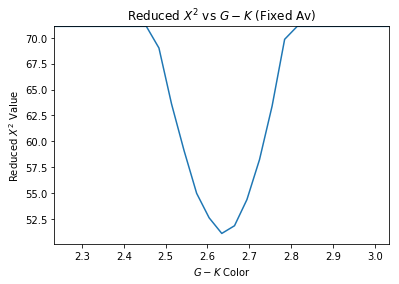

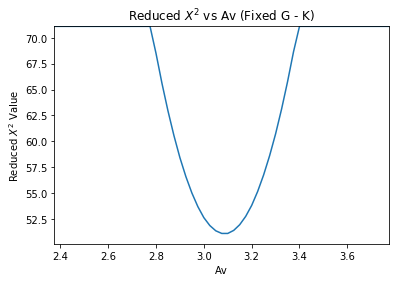

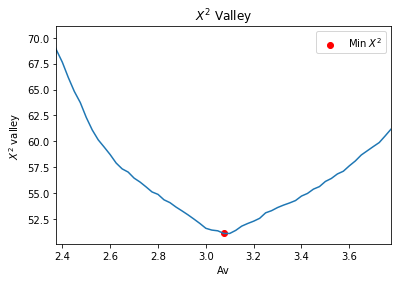

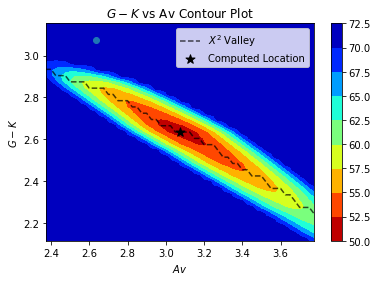

Reduced X^2: 51.1052425282116 

Star SNR: 176.53188749560812
Star Color: 4.595153000000001
Gaia Extinction: 2.898
Computed Av: 3.075
Ratio: 1.0610766045548654
Computed StarColor (G-K): 2.6343683462217227


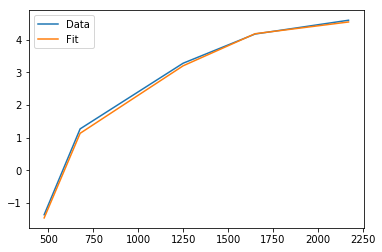

Index: 0 


Diff in G-GB Divided by Error: 7.266665980446626
Diff in G-GR Divided by Error: 13.830589662363453
Diff in G-J Divided by Error: 3.25552323338865
Diff in G-H Divided by Error: -0.2823070410747714
Diff in G-K Divided by Error: 0.8708840177826098
[0.004      0.01282821 0.00897027 0.024      0.031      0.061     ]
Total Time: 8.504726648330688


In [98]:
start = time.time()
m1 = 196
bestStarYet = 157
#n = np.random.randint(0,len(GaiaExt))
#n = 157
AG_val = GaiaExt[n]
starSNR = AG_SNR[n]

ApplyFactors = False


br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
Temps = br['Temps']

GKvals = []
AvChi = []
fits = []
allChi2Vals = []
RedChi2List = []

QuadErrors = []
extBands = RelBands[n]

MagUncert = []
starGaiaFlux = starGaiaFluxs[n]
starGaiaFlux_er = starGaiaFlux_ers[n]
TmassError = TmassErrors[n]

for i in range(len(starGaiaFlux)):
    flux = starGaiaFlux[i]
    flux_er = starGaiaFlux_er[i]
    if(i == 0):
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.01)
        MagUncert.append(Mag_er)
    else:
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.03)
        MagUncert.append(Mag_er)
MagUncert = np.array(MagUncert)
MagUncert = np.append(MagUncert, TmassError)

AV_list = np.array(br['Av'])
for i in range(len(AV_list)):

    curAv = Temps[AV_list[i]]
    colors = np.array(curAv['Colors'])
    errors = np.array(curAv['Errors'])
    if(ApplyFactors == True):
        colors[:,0] = colors[:,0]*bestGBfactor
        colors[:,1] = colors[:,1]*bestGRfactor
        colors[:,2] = colors[:,2]*bestJfactor
        colors[:,3] = colors[:,3]*bestHfactor
        colors[:,4] = colors[:,4]*bestKfactor
    
    Chi2 = []
   
    fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors,MagUncert,errors)
    
    AvChi.append(chi)
    GKvals.append(GKval)
    fits.append(fit)
    allChi2Vals.append(chi)
    RedChi2List.append(chi_array)
    QuadErrors.append(Quad)
allChi2Vals = np.array(allChi2Vals)
RedChi2List = np.array(RedChi2List)
for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        #all_Av.append(abs(AV_list[i]-AO))
        ext = AV_list[i]
        mags = Temps[AV_list[i]]
        chi_val = AvChi[i]
        #all_chi.append(chi_val)
        GK_val = GKvals[i]
        bestfit = fits[i]
        index = i
        AllChisGK = RedChi2List[i]
        quadError = QuadErrors[i]
bestTemp = mags['Colors']
bestFit = np.array(bestTemp[bestfit])
# #####

# # FIRST PLOT


# plt.xlabel('Av')
# plt.ylabel('Reduced $X^2$ Value')
# plt.ylim(chi_val-1.0,chi_val+50)
# plt.xlim(ext-1,ext+1)
# plt.title('Reduced X^2 vs Av')
# plt.legend()
# plt.show()

curAv = Temps[AV_list[0]]
colorsZeroAv = np.array(curAv['Colors'])



X, Y = np.meshgrid(AV_list,colorsZeroAv[:,4])

XY = np.transpose([X,Y])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = np.array(copy.copy(RedChi2List))
Chi2List = Chi2List.ravel()    

test = np.array(copy.copy(Chi2List))
all_vals = np.reshape(test, (-1, 1))

all_vals = all_vals[:,0]
minChi = np.min(all_vals)
for i in range(len(all_vals)):
    if(all_vals[i] > chi_val+20):
        all_vals[i] = chi_val+20

x = len(colors)
y = len(AV_list)
all_vals = np.resize(all_vals, (y ,x))
all_vals = np.transpose(all_vals)

for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        
        index = i
# End For loop
     
# SECOND PLOT
plt.plot(colorsZeroAv[:,4],all_vals[:,index])
plt.ylim(chi_val-1,chi_val+20)
plt.xlim(GK_val-0.4,GK_val+0.4)
plt.title('Reduced $X^2$ vs $G-K$ (Fixed Av)')
plt.xlabel('$G-K$ Color')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

GKcolors = np.array(copy.copy(colorsZeroAv[:,4]))
for i in range(len(GKcolors)):
    if(GKcolors[i] == GK_val):
        index2 = i
# THIRD PLOT
plt.plot(AV_list,all_vals[index2,:])
plt.ylim(chi_val-1,chi_val+20)
plt.xlim(ext-0.7,ext+0.7)
plt.title('Reduced $X^2$ vs Av (Fixed G - K)')
plt.xlabel('Av')
plt.ylabel('Reduced $X^2$ Value')
plt.show()



# listAv = []
# cutChi2 = []
# for i in range(len(allChi2Vals)):
#     if(allChi2Vals[i] <= chi_val+20):
#         listAv.append(AV_list[i])
#         cutChi2.append(allChi2Vals[i])
# listAv = np.array(listAv)
# cutChi2 = np.array(cutChi2)
# plt.plot(listAv,cutChi2,'--',label='Data')
# #plt.scatter(ext,chi_val,c='r')
# xrange = np.linspace(np.min(listAv),np.max(listAv),1000)
# coefs = poly.polyfit(listAv, cutChi2, 2)
# ffit = poly.polyval(xrange, coefs)
# plt.plot(xrange, ffit, label='Fit')

plt.plot(AV_list,allChi2Vals) # Original PLot
plt.scatter(ext,chi_val,c='r',label='Min $X^2$')
plt.xlabel('Av')
plt.ylabel('$X^2$ valley')
plt.ylim(chi_val-1.0,chi_val+20)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$X^2$ Valley')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.contourf(AV_list,colorsZeroAv[:,4],all_vals,7)
plt.set_cmap('jet_r')
plt.colorbar()
plt.xlabel('$Av$')
plt.ylabel('$G-K$')
plt.scatter(ext,GK_val,marker='*',label='Computed Location',c='k',s=90.0)
plt.plot(AV_list,GKvals,'k--',alpha=0.7,label='$X^2$ Valley')
plt.scatter(GK_val,ext)
plt.ylim(GK_val-.52,GK_val+.52)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$G-K$ vs Av Contour Plot')
plt.legend()
plt.show()
#plt.savefig('AvFit.eps', format='eps', dpi=1000)

# ffit = list(ffit)
# fitMin = np.min(ffit)
# INDEX = ffit.index(fitMin)
# extinction = xrange[INDEX]
# extinction = round(extinction, 3)
print('Reduced X^2:',chi_val,'\n') 
print('Star SNR:',starSNR)
print('Star Color:', extBands[4])
print('Gaia Extinction:',AG_val)
print('Computed Av:',ext)
print('Ratio:',ext/AG_val)
# print('Parabola Fitted Extinction:',extinction)
# print('Ratio:',extinction/AG_val)
print('Computed StarColor (G-K):',GK_val)

wvl = [477,677,1250,1650,2170]
plt.plot(wvl,extBands,label='Data')
plt.plot(wvl,bestFit,label='Fit')
plt.legend()
plt.show()
if(ApplyFactors == False):
    diffGB = extBands[0] - bestFit[0]
    diffGR = extBands[1] - bestFit[1]
    diffJ = extBands[2] - bestFit[2]
    diffH = extBands[3] - bestFit[3]
    diffK = extBands[4] - bestFit[4]
if(ApplyFactors == True):
    diffGB = extBands[0] - bestFit[0]*bestGBfactor
    diffGR = extBands[1] - bestFit[1]*bestGRfactor
    diffJ = extBands[2] - bestFit[2]*bestJfactor
    diffH = extBands[3] - bestFit[3]*bestHfactor
    diffK = extBands[4] - bestFit[4]*bestKfactor
print('Index:',n,'\n')
print('\nDiff in G-GB Divided by Error:',diffGB/quadError[0])
print('Diff in G-GR Divided by Error:',diffGR/quadError[1])
print('Diff in G-J Divided by Error:',diffJ/quadError[2])
print('Diff in G-H Divided by Error:',diffH/quadError[3])
print('Diff in G-K Divided by Error:',diffK/quadError[4])
#print(quadError)
print(MagUncert)
# chiSquaredArray = np.array([(diffGB/quadError[0])**2,(diffGR/quadError[1])**2,(diffJ/quadError[2])**2,(diffH/quadError[3])**2,\
#                   (diffK/quadError[4])**2])
# print((np.sum(chiSquaredArray))/5)
end = time.time()
print('Total Time:',end-start)

In [180]:
table = pickle.load( open( "Extinction_FiltersAll_G2_dr2_CCM_Rv_4.1.txt", "rb" ) )     

G_Ks = table['G_K_int']
#rint(AV_list[168])
print(np.max(G_Ks))


3.206102224059342


In [14]:
dic_AF = pickle.load( open( "AF_4.1_table.pickle", "rb" ) )     
AV_list = dic_AF['Av']
GK_int = dic_AF['G_K_int']
#rint(AV_list[168])
AF_vals = dic_AF['AF_list']

#print(dic_AF.keys())
# print('Ag Table value:',(AF_vals['GK_int'][index2][0][index]))
# print('Table Ratio:',AV_list[index]/(AF_vals['GK_int'][index2][0][index]))
# print('Ratio:',AV_list[index]/AG_val)

Index: 1 



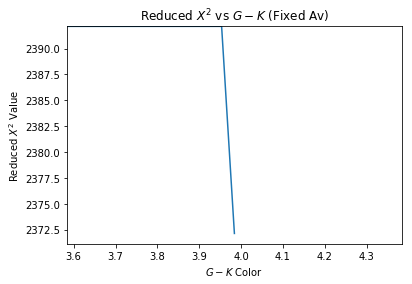

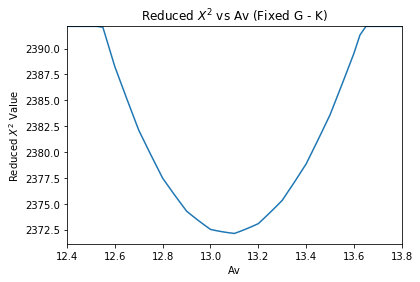

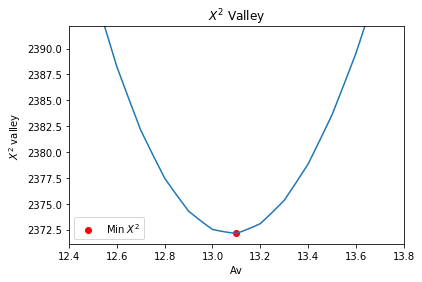

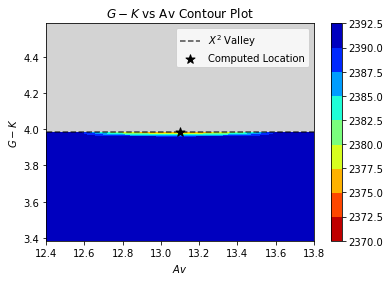

Reduced X^2: 2372.1425106882048 

Star SNR: 154.4592821670913
Star G-K: 10.430104
Computed Av: 13.1
Computed StarColor (G-K): 3.984043974625437


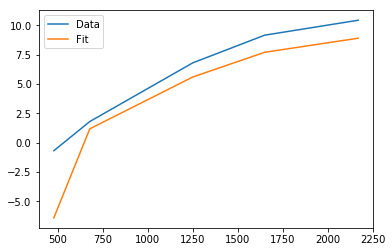


Diff in G-GB Divided by Error: 25.93247537254508
Diff in G-GR Divided by Error: 41.260182859960416
Diff in G-J Divided by Error: 40.18889648708909
Diff in G-H Divided by Error: 57.58019881616575
Diff in G-K Divided by Error: 67.49214686388972
[0.0044457  0.2006231  0.01323707 0.023      0.022      0.019     ]
Total Time: 5.2207276821136475


In [346]:
start = time.time()
saveIndex = [7441, 52]
#n = np.random.randint(0,len(noAG_bands))
n = 1
ApplyFactors = True

#n = 13
#AG_val = nanAG[n]
print('Index:',n,'\n')
br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
Temps = br['Temps']

GKvals = []
AvChi = []
fits = []
allChi2Vals = []
RedChi2List = []

QuadErrors = []
extBands = noAG_bands[n]

MagUncert = []

starGaiaFlux = noAGstarGaiaFluxs[n]
starGaiaFlux_er = noAGstarGaiaFlux_ers[n]
TmassError = noAGTmassErrors[n]

starSNR = starGaiaFlux[0]/starGaiaFlux_er[0]

for i in range(len(starGaiaFlux)):
    flux = starGaiaFlux[i]
    flux_er = starGaiaFlux_er[i]
    if(i == 0):
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.01)
        MagUncert.append(Mag_er)
    else:
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.03)
        MagUncert.append(Mag_er)
MagUncert = np.array(MagUncert)
MagUncert = np.append(MagUncert, TmassError)

AV_list = np.array(br['Av'])
for i in range(len(AV_list)):

    curAv = Temps[AV_list[i]]
    colors = np.array(curAv['Colors'])
    errors = np.array(curAv['Errors'])
    if(ApplyFactors == True):
        colors[:,0] = colors[:,0]*bestGBfactor
        colors[:,1] = colors[:,1]*bestGRfactor
        colors[:,2] = colors[:,2]*bestJfactor
        colors[:,3] = colors[:,3]*bestHfactor
        colors[:,4] = colors[:,4]*bestKfactor
    
    Chi2 = []
   
    fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors,MagUncert,errors)
    
    AvChi.append(chi)
    GKvals.append(GKval)
    fits.append(fit)
    allChi2Vals.append(chi)
    RedChi2List.append(chi_array)
    QuadErrors.append(Quad)
allChi2Vals = np.array(allChi2Vals)
RedChi2List = np.array(RedChi2List)
for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        #all_Av.append(abs(AV_list[i]-AO))
        ext = AV_list[i]
        mags = Temps[AV_list[i]]
        chi_val = AvChi[i]
        #all_chi.append(chi_val)
        GK_val = GKvals[i]
        bestfit = fits[i]
        index = i
        AllChisGK = RedChi2List[i]
        quadError = QuadErrors[i]
bestTemp = mags['Colors']
bestFit = np.array(bestTemp[bestfit])

curAv = Temps[AV_list[0]]
colorsZeroAv = np.array(curAv['Colors'])


X, Y = np.meshgrid(AV_list,colorsZeroAv[:,4])

XY = np.transpose([X,Y])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = np.array(copy.copy(RedChi2List))
Chi2List = Chi2List.ravel()    

test = np.array(copy.copy(Chi2List))
all_vals = np.reshape(test, (-1, 1))

all_vals = all_vals[:,0]
minChi = np.min(all_vals)
for i in range(len(all_vals)):
    if(all_vals[i] > chi_val+20):
        all_vals[i] = chi_val+20

x = len(colors)
y = len(AV_list)
all_vals = np.resize(all_vals, (y ,x))
all_vals = np.transpose(all_vals)

for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        
        index = i
# End For loop
     
# SECOND PLOT
plt.plot(colorsZeroAv[:,4],all_vals[:,index])
plt.ylim(chi_val-1,chi_val+20)
plt.xlim(GK_val-0.4,GK_val+0.4)
plt.title('Reduced $X^2$ vs $G-K$ (Fixed Av)')
plt.xlabel('$G-K$ Color')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

GKcolors = np.array(copy.copy(colorsZeroAv[:,4]))
for i in range(len(GKcolors)):
    if(GKcolors[i] == GK_val):
        index2 = i
# THIRD PLOT
plt.plot(AV_list,all_vals[index2,:])
plt.ylim(chi_val-1,chi_val+20)
plt.xlim(ext-0.7,ext+0.7)
plt.title('Reduced $X^2$ vs Av (Fixed G - K)')
plt.xlabel('Av')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

plt.plot(AV_list,allChi2Vals) # Original PLot
plt.scatter(ext,chi_val,c='r',label='Min $X^2$')
plt.xlabel('Av')
plt.ylabel('$X^2$ valley')
plt.ylim(chi_val-1.0,chi_val+20)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$X^2$ Valley')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.contourf(AV_list,colorsZeroAv[:,4],all_vals,7)
plt.set_cmap('jet_r')
plt.colorbar()
plt.xlabel('$Av$')
plt.ylabel('$G-K$')
plt.scatter(ext,GK_val,marker='*',label='Computed Location',c='k',s=90.0)
plt.plot(AV_list,GKvals,'k--',alpha=0.7,label='$X^2$ Valley')
#plt.scatter(GK_val,ext)
plt.ylim(GK_val-0.6,GK_val+0.6)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$G-K$ vs Av Contour Plot')
plt.legend()
plt.show()

print('Reduced X^2:',chi_val,'\n') 
print('Star SNR:',starSNR)
print('Star G-K:',extBands[4])
print('Computed Av:',ext)
print('Computed StarColor (G-K):',GK_val)
#print('Ratio of Colors:',extBands[4]/GK_val)
wvl = [477,677,1250,1650,2170]
plt.plot(wvl,extBands,label='Data')
plt.plot(wvl,bestFit,label='Fit')
plt.legend()
plt.show()
if(ApplyFactors == False):
    diffGB = extBands[0] - bestFit[0]
    diffGR = extBands[1] - bestFit[1]
    diffJ = extBands[2] - bestFit[2]
    diffH = extBands[3] - bestFit[3]
    diffK = extBands[4] - bestFit[4]
if(ApplyFactors == True):
    diffGB = extBands[0] - bestFit[0]*bestGBfactor
    diffGR = extBands[1] - bestFit[1]*bestGRfactor
    diffJ = extBands[2] - bestFit[2]*bestJfactor
    diffH = extBands[3] - bestFit[3]*bestHfactor
    diffK = extBands[4] - bestFit[4]*bestKfactor
print('\nDiff in G-GB Divided by Error:',diffGB/quadError[0])
print('Diff in G-GR Divided by Error:',diffGR/quadError[1])
print('Diff in G-J Divided by Error:',diffJ/quadError[2])
print('Diff in G-H Divided by Error:',diffH/quadError[3])
print('Diff in G-K Divided by Error:',diffK/quadError[4])
#print(quadError)
print(MagUncert)
end = time.time()
print('Total Time:',end-start)

In [44]:
goodStars = [6918, 2989, 2989, 6325, 1878, 5068, 1631, 7482, 4800, 6018, 1221, 8345]

In [45]:
goodStars.append(n)

print(goodStars)

[6918, 2989, 2989, 6325, 1878, 5068, 1631, 7482, 4800, 6018, 1221, 8345, 13]


In [11]:
cornerRA = []
cornerDEC = []
G = []
GB = []
GR = []
Gflux = []
GBflux = []
GRflux = []
Gflux_err = []
GBflux_err = []
GRflux_err = []

J = []
H = []
K = []
Jerr = []
Herr = []
Kerr = []
ag = []
for i in range(len(RA)):
    if(RA[i] >= 248.35 and DEC[i] <= -25.0 and str(Gmag[i]) != 'nan' and str(GBmag[i]) != 'nan' and \
       str(GRmag[i]) != 'nan' and SNR[i] >= 400\
       and str(Jmag[i]) != 'nan' and str(Hmag[i]) != 'nan' and str(Kmag[i]) != 'nan' and str(G_flux[i]) != 'nan'\
       and str(GB_flux[i]) != 'nan' and str(GR_flux[i]) != 'nan' and str(G_flux_er[i]) != 'nan' and str(GB_flux_er[i]) != 'nan'\
       and str(GR_flux_er[i]) != 'nan' and str(J_unc[i]) != 'nan' and str(H_unc[i]) != 'nan' and str(K_unc[i]) != 'nan') :
        G.append(Gmag[i])
        GB.append(GBmag[i])
        GR.append(GRmag[i])
        Gflux.append(G_flux[i])
        Gflux_err.append(G_flux_er[i])
        GBflux.append(GB_flux[i])
        GBflux_err.append(GB_flux_er[i])
        GRflux.append(GR_flux[i])
        GRflux_err.append(GR_flux_er[i])
        J.append(Jmag[i])
        H.append(Hmag[i])
        K.append(Kmag[i])
        Jerr.append(J_unc[i])
        Herr.append(H_unc[i])
        Kerr.append(K_unc[i])
        ag.append(AG[i])
        cornerRA.append(RA[i])
        cornerDEC.append(DEC[i])
G = np.array(G)
GB = np.array(GB)
GR = np.array(GR)
Gflux = np.array(Gflux)
GBflux = np.array(GBflux)
GRflux = np.array(GRflux)
Gflux_err = np.array(Gflux_err)
GBflux_err = np.array(GBflux_err)
GRflux_err = np.array(GRflux_err)
cornerRA = np.array(cornerRA)
cornerDEC = np.array(cornerDEC)
J = np.array(J)
H = np.array(H)
K = np.array(K)
Jerr = np.array(Jerr)
Herr = np.array(Herr)
Kerr = np.array(Kerr)
ag = np.array(ag)

GGB = G - GB
GGR = G - GR
GJ = G - J
GH = G - H
GK = G - K

cornerGaiaFluxs = np.array([Gflux[0],GBflux[0],GRflux[0]])
cornerGaiaFlux_ers = np.array([Gflux_err[0],GBflux_err[0],GRflux_err[0]])
cornerTmassErrors = np.array([Jerr[0],Herr[0],Kerr[0]])
cornerBands = np.array([GGB[0],GGR[0],GJ[0],GH[0],GK[0]])
#cornerBands = np.array([GGR[0],GJ[0],GH[0],GK[0]])


for i in range(1,len(G)):
    cornerGaiaFluxs = np.vstack((cornerGaiaFluxs,[Gflux[i],GBflux[i],GRflux[i]]))
    cornerGaiaFlux_ers = np.vstack((cornerGaiaFlux_ers,[Gflux_err[i],GBflux_err[i],GRflux_err[i]]))
    cornerTmassErrors = np.vstack((cornerTmassErrors,[Jerr[i],Herr[i],Kerr[i]]))
    cornerBands = np.vstack((cornerBands, [GGB[i],GGR[i],GJ[i],GH[i],GK[i]]))
    #cornerBands = np.vstack((cornerBands, [GGR[i],GJ[i],GH[i],GK[i]]))

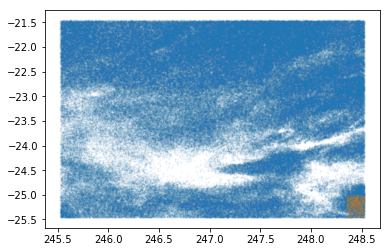

714


In [12]:
plt.scatter(RA,DEC,s=1.0,alpha=0.05)
plt.scatter(cornerRA,cornerDEC,s=1.0,alpha=0.08)
#plt.scatter(cornerRA[n],cornerDEC[n],c='r')
plt.show()
print(len(G))

In [132]:
v = np.array([1,2,3])
v = v[~np.isnan(v)]
v = np.array(v)
v[0] = v[0]*2
print(v)

[2 2 3]


In [161]:
print(colors[0])

colors[:,0] = colors[:,0]*factorGB
colors[:,1] = colors[:,1]*factorGR

print(colors[0])

[-6.28742213  0.7123986   4.30443758  6.64356465  8.13544107]
[-5.83095529  0.73270196  4.30443758  6.64356465  8.13544107]


Total Time: 2.5436887741088867


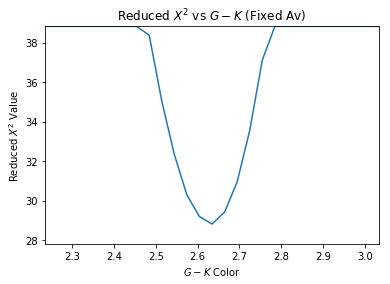

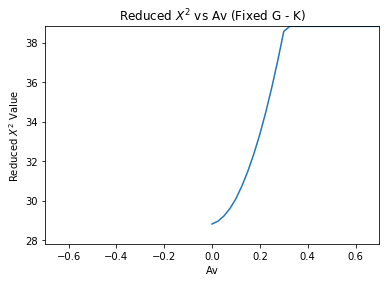

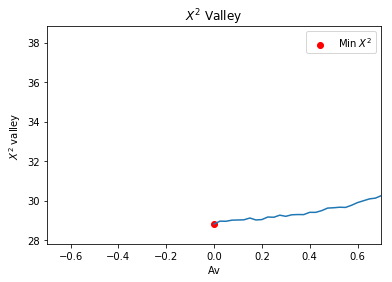

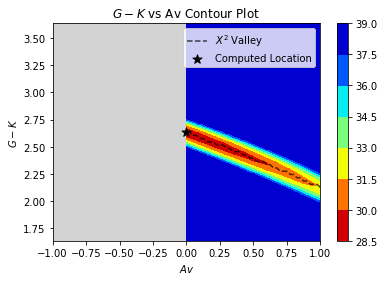


Index: 580
Reduced X^2: 28.819734251653067 

Star SNR: 655.5351568925212
Star G-K: 3.0771569999999997
Computed Av: 0.0
COMPUTED AV: 0.0
Computed StarColor (G-K): 2.6343683462217227


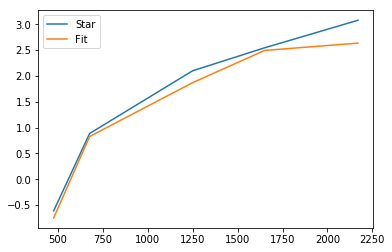


Diff in G-GB: -0.13628521889759615
Diff in G-GR: -0.05840921122040377
Diff in G-J: -0.2301277623316631
Diff in G-H: -0.05067779479704271
Diff in G-K: -0.44278865377827703

Diff in G-GB Divided by Error: -9.374335310323467
Diff in G-GR Divided by Error: -6.7268426014543445
Diff in G-J Divided by Error: -1.9327312743524796
Diff in G-H Divided by Error: -0.35179005790829765
Diff in G-K Divided by Error: -2.6666253841594614
Star Error: [0.004      0.01397342 0.00770434 0.119      0.144      0.166     ]
Quad Error: [0.01453812 0.00868301 0.11906868 0.14405693 0.16604832]


In [22]:
# FOR STARS IN THE CORNER OF THE REGION OF THE CLOUD
all_chi = []
all_Av = []
start = time.time()
saveIndex = [2008]

#n = np.random.randint(0,len(cornerBands))
#n = 328
ApplyFactors = False

extBands = cornerBands[n]
MagUncert = []

starGaiaFlux = cornerGaiaFluxs[n]
starGaiaFlux_er = cornerGaiaFlux_ers[n]
TmassError = cornerTmassErrors[n]

starSNR = starGaiaFlux[0]/starGaiaFlux_er[0]

for i in range(len(starGaiaFlux)):
    flux = starGaiaFlux[i]
    flux_er = starGaiaFlux_er[i]
    if(i == 0):
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.01)
        MagUncert.append(Mag_er)
    else:
        Mag_er = MagError(flux,flux_er,0.004)
        #Mag_er = MagError(flux,flux_er,0.03)
        MagUncert.append(Mag_er)
MagUncert = np.array(MagUncert)
MagUncert = np.append(MagUncert, TmassError)
MagUncert = MagUncert[~np.isnan(MagUncert)]

br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
Temps = br['Temps']

GKvals = []
AvChi = []
fits = []
allChi2Vals = []
RedChi2List = []
QuadErrors = []

AV_list = np.array(br['Av'])
for i in range(len(AV_list)):

    curAv = Temps[AV_list[i]]
    colors = np.array(curAv['Colors'])
    errors = np.array(curAv['Errors'])
    if(ApplyFactors == True):
        colors[:,0] = colors[:,0]*1.1
        colors[:,1] = colors[:,1]*1.1
#         colors[:,2] = colors[:,2]*bestJfactor
#         colors[:,3] = colors[:,3]*bestHfactor
#         colors[:,4] = colors[:,4]*bestKfactor

#         colors[:,0] = colors[:,0]*GBfactor6
#         colors[:,1] = colors[:,1]*GRfactor6
#         colors[:,2] = colors[:,2]*Jfactor6
#         colors[:,3] = colors[:,3]*Hfactor6
#         colors[:,4] = colors[:,4]*Kfactor6


    Chi2 = []

    fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors,MagUncert,errors)

    AvChi.append(chi)
    GKvals.append(GKval)
    fits.append(fit)
    allChi2Vals.append(chi)
    RedChi2List.append(chi_array)
    QuadErrors.append(Quad)
allChi2Vals = np.array(allChi2Vals)
RedChi2List = np.array(RedChi2List)
minVal = np.min(AvChi)
indexValue = AvChi.index(minVal)
extinction = AV_list[indexValue]
for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        all_Av.append(AV_list[i])
        ext = AV_list[i]
        mags = Temps[AV_list[i]]
        chi_val = AvChi[i]
        all_chi.append(allChi2Vals[i])
        GK_val = GKvals[i]
        bestfit = fits[i]
        index = i
        AllChisGK = RedChi2List[i]
        quadError = QuadErrors[i]
end = time.time()
print('Total Time:',end-start)
bestTemp = mags['Colors']
bestFit = np.array(bestTemp[bestfit])

curAv = Temps[AV_list[0]]
colorsZeroAv = np.array(curAv['Colors'])


X, Y = np.meshgrid(AV_list,colorsZeroAv[:,4])

XY = np.transpose([X,Y])
grid = XY[0]

for j in range(1,len(XY)):
    grid = np.vstack((grid,XY[j]))

Chi2List = np.array(copy.copy(RedChi2List))
Chi2List = Chi2List.ravel()    

test = np.array(copy.copy(Chi2List))
all_vals = np.reshape(test, (-1, 1))

all_vals = all_vals[:,0]
minChi = np.min(all_vals)
for i in range(len(all_vals)):
    if(all_vals[i] > chi_val+10):
        all_vals[i] = chi_val+10

x = len(colors)
y = len(AV_list)
all_vals = np.resize(all_vals, (y ,x))
all_vals = np.transpose(all_vals)

for i in range(len(AvChi)):
    if(AvChi[i] == np.min(AvChi)):
        
        index = i
# End For loop
     
# SECOND PLOT
plt.plot(colorsZeroAv[:,4],all_vals[:,index])
plt.ylim(chi_val-1,chi_val+10)
plt.xlim(GK_val-0.4,GK_val+0.4)
plt.title('Reduced $X^2$ vs $G-K$ (Fixed Av)')
plt.xlabel('$G-K$ Color')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

GKcolors = np.array(copy.copy(colorsZeroAv[:,4]))
for i in range(len(GKcolors)):
    if(GKcolors[i] == GK_val):
        index2 = i
# THIRD PLOT
plt.plot(AV_list,all_vals[index2,:])
plt.ylim(chi_val-1,chi_val+10)
plt.xlim(ext-0.7,ext+0.7)
plt.title('Reduced $X^2$ vs Av (Fixed G - K)')
plt.xlabel('Av')
plt.ylabel('Reduced $X^2$ Value')
plt.show()

plt.plot(AV_list,allChi2Vals) # Original PLot
plt.scatter(ext,chi_val,c='r',label='Min $X^2$')
plt.xlabel('Av')
plt.ylabel('$X^2$ valley')
plt.ylim(chi_val-1.0,chi_val+10)
plt.xlim(ext-0.7,ext+0.7)
plt.title('$X^2$ Valley')
plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.contourf(AV_list,colorsZeroAv[:,4],all_vals,7)
plt.set_cmap('jet_r')
plt.colorbar()
plt.xlabel('$Av$')
plt.ylabel('$G-K$')
plt.scatter(ext,GK_val,marker='*',label='Computed Location',c='k',s=90.0)
plt.plot(AV_list,GKvals,'k--',alpha=0.7,label='$X^2$ Valley')
#plt.scatter(GK_val,ext)
plt.ylim(GK_val-1.0,GK_val+1.0)
plt.xlim(ext-1.0,ext+1.0)
plt.title('$G-K$ vs Av Contour Plot')
plt.legend()
plt.show()
print('\nIndex:',n)
print('Reduced X^2:',chi_val,'\n') 
print('Star SNR:',starSNR)
print('Star G-K:',extBands[4])
print('Computed Av:',ext)
print('COMPUTED AV:',extinction)
print('Computed StarColor (G-K):',GK_val)
#print('Ratio of Colors:',extBands[4]/GK_val)
wvl = [477,677,1250,1650,2170]
plt.plot(wvl,extBands,label='Star')
plt.plot(wvl,bestFit,label='Fit')
DataArray = np.array([[bestFit,extBands]])
plt.legend()
plt.show()
if(ApplyFactors == False):
    diffGB = bestFit[0] - extBands[0]
    diffGR = bestFit[1] - extBands[1]
    diffJ = bestFit[2] - extBands[2]
    diffH = bestFit[3] - extBands[3]
    diffK = bestFit[4] - extBands[4]
if(ApplyFactors == True):
    diffGB = bestFit[0] - extBands[0]*1.1
    diffGR = bestFit[1] - extBands[1]*1.1
    diffJ = bestFit[2] - extBands[2]
    diffH = bestFit[3] - extBands[3]
    diffK = bestFit[4] - extBands[4]
    
#     diffGB = extBands[0] - bestFit[0]#*GBfactor6
#     diffGR = extBands[1] - bestFit[1]#*GRfactor6
#     diffJ = extBands[2] - bestFit[2]*Jfactor6
#     diffH = extBands[3] - bestFit[3]*Hfactor6
#     diffK = extBands[4] - bestFit[4]*Kfactor6
print('\nDiff in G-GB:',diffGB)
print('Diff in G-GR:',diffGR)
print('Diff in G-J:',diffJ)
print('Diff in G-H:',diffH)
print('Diff in G-K:',diffK)

print('\nDiff in G-GB Divided by Error:',diffGB/quadError[0])
print('Diff in G-GR Divided by Error:',diffGR/quadError[1])
print('Diff in G-J Divided by Error:',diffJ/quadError[2])
print('Diff in G-H Divided by Error:',diffH/quadError[3])
print('Diff in G-K Divided by Error:',diffK/quadError[4])
print('Star Error:',MagUncert)
print('Quad Error:',quadError)

In [73]:
bestGBfactor

0.9188181818181819

[[-0.76326781  0.8365503   1.89303075  2.52039206  2.66477727]
 [-0.598944    1.001872    2.22378     2.67078     2.67878   ]]


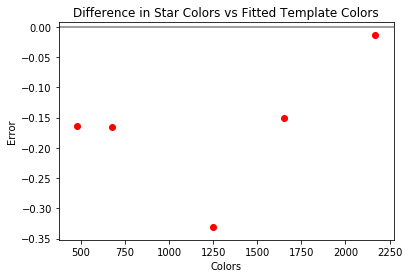


Median GB Error: -0.16432380706196825
Median GR Error: -0.16532170302359372
Median J Error: -0.3307492475985241
Median H Error: -0.15038794203939965
Median K Error: -0.014002732232238468


In [72]:
print(DataArray[0])
data = CheckError(DataArray,1,1,1,1,1,)

In [23]:
ID = np.zeros(70)
start = time.time()
for i in range(len(ID)):
    n = np.random.randint(0,len(cornerBands))
    ID[i] = int(n)
#print(ID)
end = time.time()

In [28]:

start = time.time()
saveIndex = [166, 5434, 3556]
br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
#br = pickle.load(open('Giants_Av_CCM_4.1.pickle', 'rb'))

Av1 = []
Av2 = []
Av3 = []
Av4 = []
Av5 = []
Av6 = []
Av7 = []
Av8 = []
Av9 = []
Av10 = []
Av11 = []
Av12 = []
Av13 = []
Av14 = []
Av15 = []
Av16 = []
Av17 = []
Av18 = []
Av19 = []
Av20 = []

for m in range(len(ID)):
    
    #n = np.random.randint(0,len(cornerBands))
    
    extBands = cornerBands[int(ID[m])]
    extBands = extBands[~np.isnan(extBands)]
    MagUncert = []

    starGaiaFlux = cornerGaiaFluxs[n]
    starGaiaFlux_er = cornerGaiaFlux_ers[n]
    TmassError = cornerTmassErrors[n]

    starSNR = starGaiaFlux[0]/starGaiaFlux_er[0]

    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            Mag_er = MagError(flux,flux_er,0.004)
            MagUncert.append(Mag_er)
        else:
            Mag_er = MagError(flux,flux_er,0.004)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)
    MagUncert = MagUncert[~np.isnan(MagUncert)]

       
    Temps = br['Temps']
    AvChi = []
    GKvals = []
    fits = []
    AV_list = np.array(br['Av'])
    for i in range(len(AV_list)):

        curAv = Temps[AV_list[i]]
        colors = np.array(curAv['Colors'])
        errors = np.array(curAv['Errors'])
        
        
        fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors,MagUncert,errors)

        AvChi.append(chi)
        GKvals.append(GKval)
        fits.append(fit)
    minVal = np.min(AvChi)
    indexValue = AvChi.index(minVal)
    av = AV_list[indexValue]
    extinction = AV_list[indexValue]
    extinction = 0.1
    bestfit = fits[indexValue]
    mags = Temps[AV_list[indexValue]]
    bestTemp = mags['Colors']
    Fit = np.array(bestTemp[bestfit])
    
    error = np.array(mags['Errors'][bestfit])
    GK_val = GKvals[indexValue]
    
    
    if(extinction <= 0.25 and GK_val <= 3.0):
        Av1.append([Fit,extBands])
    elif(extinction > 0.25 and extinction <= 0.5 and GK_val <= 3.0):
        Av2.append([Fit,extBands])
    elif(extinction > 0.5 and extinction <= 0.75 and GK_val <= 3.0):
        Av3.append([Fit,extBands])
    elif(extinction > 0.75 and extinction <= 1.0 and GK_val <= 3.0):
        Av4.append([Fit,extBands])
    elif(extinction > 1.0 and extinction <= 1.25 and GK_val <= 3.0):
        Av5.append([Fit,extBands])
    elif(extinction > 1.25 and extinction <= 1.5 and GK_val <= 3.0):
        Av6.append([Fit,extBands])
    elif(extinction > 1.5 and extinction <= 1.75 and GK_val <= 3.0):
        Av7.append([Fit,extBands])
    elif(extinction > 1.75 and extinction <= 2.0 and GK_val <= 3.0):
        Av8.append([Fit,extBands])
    elif(extinction > 2.0 and extinction <= 2.25 and GK_val <= 3.0):
        Av9.append([Fit,extBands])
    elif(extinction > 2.25 and extinction <= 2.5 and GK_val <= 3.0):
        Av10.append([Fit,extBands])
    elif(extinction > 2.5 and extinction <= 2.75 and GK_val <= 3.0):
        Av11.append([Fit,extBands])
    elif(extinction > 2.75 and extinction <= 3.0 and GK_val <= 3.0):
        Av12.append([Fit,extBands])
    elif(extinction > 3.0 and extinction <= 3.25 and GK_val <= 3.0):
        Av13.append([Fit,extBands])
    elif(extinction > 3.25 and extinction <= 3.5 and GK_val <= 3.0):
        Av14.append([Fit,extBands])
    elif(extinction > 3.5 and extinction <= 3.75 and GK_val <= 3.0):
        Av15.append([Fit,extBands])
    elif(extinction > 3.75 and extinction <= 4.0 and GK_val <= 3.0):
        Av16.append([Fit,extBands])
    elif(extinction > 4.0 and extinction <= 4.25 and GK_val <= 3.0):
        Av17.append([Fit,extBands])
    elif(extinction > 4.25 and extinction <= 4.5 and GK_val <= 3.0):
        Av18.append([Fit,extBands])
    elif(extinction > 4.5 and extinction <= 4.75 and GK_val <= 3.0):
        Av19.append([Fit,extBands])
    elif(extinction > 4.75 and extinction <= 5.0 and GK_val <= 3.0):
        Av20.append([Fit,extBands])
        
        
Av1 = np.array(Av1)
Av2 = np.array(Av2)
Av3 = np.array(Av3)
Av4 = np.array(Av4)
Av5 = np.array(Av5)
Av6 = np.array(Av6)
Av7 = np.array(Av7)
Av8 = np.array(Av8)
Av9 = np.array(Av9)
Av10 = np.array(Av10)
Av11 = np.array(Av11)
Av12 = np.array(Av12)
Av13 = np.array(Av13)
Av14 = np.array(Av14)
Av15 = np.array(Av15)
Av16 = np.array(Av16)
Av17 = np.array(Av17)
Av18 = np.array(Av18)
Av19 = np.array(Av19)
Av20 = np.array(Av20)

end = time.time()
print('Total Time:',end-start)
print('\nReal Av:',av)
print('G-K:',GK_val)
print('chi:',minVal)

Total Time: 210.87824654579163

Real Av: 0.75
G-K: 2.5442419019135287
chi: 21.663822602248242


All Av's
204


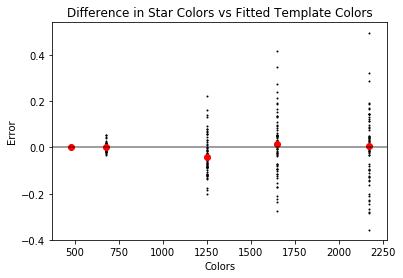


Median GB Error: 0.0023942762747695134
Median GR Error: 0.0023584730830529255
Median J Error: -0.04019610419402553
Median H Error: 0.013479456670162815
Median K Error: 0.008105952935681282


In [27]:
# USING THE ADJUSTED AV TEMPLATES
print("All Av's")
print(n)
medians = CheckError(Av,1,1,1,1,1)


Increaing the Av Value for the Fitted Templates
204


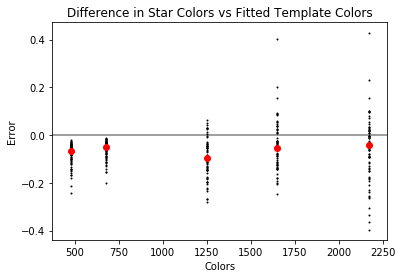


Median GB Error: -0.06475990816071714
Median GR Error: -0.04935807187335528
Median J Error: -0.0940555022025149
Median H Error: -0.053125849761851196
Median K Error: -0.042627124721382526


In [29]:
# USING ORIGINAL AV TEMPLATES
print("Increaing the Av Value for the Fitted Templates")
print(n)
medians = CheckError(Av1,1,1,1,1,1)


In [30]:
print('hi')

hi


Increaing the Av Value for the Fitted Templates
687


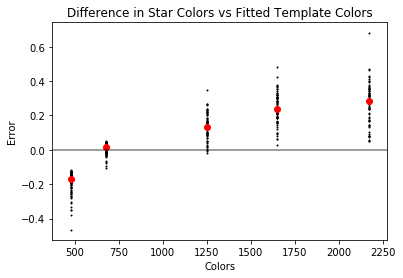


Median GB Error: -0.1672991911515006
Median GR Error: 0.015483063069423486
Median J Error: 0.13282099886624354
Median H Error: 0.23647057145162043
Median K Error: 0.2856153548418754


In [19]:
print("Increaing the Av Value for the Fitted Templates")
print(n)
medians = CheckError(Av1,1,1,1,1,1)


In [27]:
20*0.025

0.5

Increaing the Av Value for the Fitted Templates
126


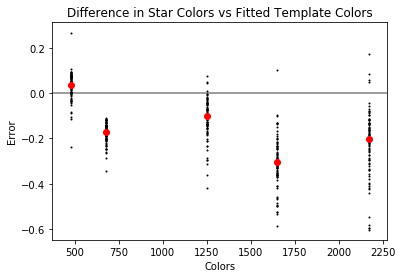


Median GB Error: 0.03842930549306711
Median GR Error: -0.17077273737520293
Median J Error: -0.1022758110552846
Median H Error: -0.3045865301993568
Median K Error: -0.20339696068963864


Increaing the Av Value for the Fitted Templates
315


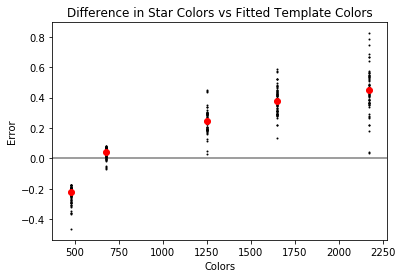


Median GB Error: -0.22138102604631382
Median GR Error: 0.03989863097709462
Median J Error: 0.2442097315019387
Median H Error: 0.37563708388054584
Median K Error: 0.4483901572017208


In [29]:
print("Increaing the Av Value for the Fitted Templates")
print(n)
medians = CheckError(Av1,1,1,1,1,1)


In [26]:
####### FirstAv 0.0 - 1.0
wvl = [477,677,1250,1650,2170]

def CheckError(Av,GBfactor,GRfactor,Jfactor,Hfactor,Kfactor):

    GBcolors = []
    GRcolors = []
    Jcolors = []
    Hcolors = []
    Kcolors = []
    
    for i in range(len(Av)):
        FitColors = Av[i,0]
        StarColors = Av[i,1]
        GB = (FitColors[0]*GBfactor - StarColors[0])
        GR = (FitColors[1]*GRfactor - StarColors[1])
        J = (FitColors[2]*Jfactor - StarColors[2])
        H = (FitColors[3]*Hfactor - StarColors[3])
        K = (FitColors[4]*Kfactor - StarColors[4])
        GBcolors.append(GB)
        GRcolors.append(GR)
        Jcolors.append(J)
        Hcolors.append(H)
        Kcolors.append(K)

        GBcolor = (GB)
        GRcolor = (GR)
        Jcolor = (J)
        Hcolor = (H)
        Kcolor = (K)
        allColors = [GBcolor,GRcolor,Jcolor,Hcolor,Kcolor]
        plt.scatter(wvl,allColors,c='k',s=1.0,label='Errors')

    GBmedian = np.median(GBcolors)
    GRmedian = np.median(GRcolors)
    Jmedian = np.median(Jcolors)
    Hmedian = np.median(Hcolors)
    Kmedian = np.median(Kcolors)
    allMedians = [GBmedian,GRmedian,Jmedian,Hmedian,Kmedian]
    plt.scatter(wvl,allMedians,c='r',label='Median Error')
    plt.xlabel('Colors')
    plt.ylabel('Error')
    plt.title('Difference in Star Colors vs Fitted Template Colors')
    plt.axhline(0,alpha=0.5,c='k')
    #plt.ylim(-0.1,1.1)
    plt.show()
    print('\nMedian GB Error:', GBmedian)
    print('Median GR Error:', GRmedian)
    print('Median J Error:', Jmedian)
    print('Median H Error:', Hmedian)
    print('Median K Error:', Kmedian)
    return allMedians

In [21]:
####### FirstAv 0.0 - 1.0
wvl = [477,677,1250,1650,2170]

def CalcSingleFactor(Av,GBfactor,GRfactor,Jfactor,Hfactor,Kfactor):

    GBcolors = []
    GRcolors = []
    Jcolors = []
    Hcolors = []
    Kcolors = []
    
    for i in range(len(Av)):
        FitColors = Av[i,0]
        StarColors = Av[i,1]
        GB = abs(FitColors[0]*GBfactor - StarColors[0])
        GR = abs(FitColors[1]*GRfactor - StarColors[1])
        J = abs(FitColors[2]*Jfactor - StarColors[2])
        H = abs(FitColors[3]*Hfactor - StarColors[3])
        K = abs(FitColors[4]*Kfactor - StarColors[4])
        GBcolors.append(GB)
        GRcolors.append(GR)
        Jcolors.append(J)
        Hcolors.append(H)
        Kcolors.append(K)

        GBcolor = (GB)
        GRcolor = (GR)
        Jcolor = (J)
        Hcolor = (H)
        Kcolor = (K)
        allColors = [GBcolor,GRcolor,Jcolor,Hcolor,Kcolor]
       
    GBmedian = np.median(GBcolors)
    GRmedian = np.median(GRcolors)
    Jmedian = np.median(Jcolors)
    Hmedian = np.median(Hcolors)
    Kmedian = np.median(Kcolors)
    allMedians = [GBmedian,GRmedian,Jmedian,Hmedian,Kmedian]

    return allMedians

In [22]:
def CalcFactors(AvArray1,AvArray2):
    array = []
    factors = np.arange(0.0,1.5,0.001)
    for i in range(len(factors)):
        medians = CalcSingleFactor(AvArray1,factors[i],1,1,1,1)
        array.append(medians[0])

    minVal = np.min(array)
    indexValue = array.index(minVal)
    GBfactor = factors[indexValue]

    array = []
    #factors = np.arange(0.0,1.5,0.001)
    for i in range(len(factors)):
        medians = CalcSingleFactor(AvArray2,1,factors[i],1,1,1)
        array.append(medians[1])

    minVal = np.min(array)
    indexValue = array.index(minVal)
    GRfactor = factors[indexValue]
    
    return GBfactor, GRfactor

In [234]:
GBfactor1, GRfactor1, Jfactor1, Hfactor1, Kfactor1 = CalcFactors1(Av1)
GBfactor2, GRfactor2, Jfactor2, Hfactor2, Kfactor2 = CalcFactors1(Av2)
GBfactor3, GRfactor3, Jfactor3, Hfactor3, Kfactor3 = CalcFactors1(Av3)
GBfactor4, GRfactor4, Jfactor4, Hfactor4, Kfactor4 = CalcFactors1(Av4)
GBfactor5, GRfactor5, Jfactor5, Hfactor5, Kfactor5 = CalcFactors1(Av5)
GBfactor6, GRfactor6, Jfactor6, Hfactor6, Kfactor6 = CalcFactors1(Av6)
GBfactor7, GRfactor7, Jfactor7, Hfactor7, Kfactor7 = CalcFactors1(Av7)
GBfactor8, GRfactor8, Jfactor8, Hfactor8, Kfactor8 = CalcFactors1(Av8)
GBfactor9, GRfactor9, Jfactor9, Hfactor9, Kfactor9 = CalcFactors1(Av9)
GBfactor10, GRfactor10, Jfactor10, Hfactor10, Kfactor10 = CalcFactors1(Av10)
GBfactor11, GRfactor11, Jfactor11, Hfactor11, Kfactor11 = CalcFactors1(Av11)
# GBfactor12, GRfactor12, Jfactor12, Hfactor12, Kfactor12 = CalcFactors1(Av12)
# GBfactor13, GRfactor13, Jfactor13, Hfactor13, Kfactor13 = CalcFactors1(Av13)
# GBfactor14, GRfactor14, Jfactor14, Hfactor14, Kfactor14 = CalcFactors1(Av14)
# GBfactor15, GRfactor15, Jfactor15, Hfactor15, Kfactor15 = CalcFactors1(Av15)
# GBfactor16, GRfactor16, Jfactor16, Hfactor16, Kfactor16 = CalcFactors1(Av16)
# GBfactor17, GRfactor17, Jfactor17, Hfactor17, Kfactor17 = CalcFactors1(Av17)
# GBfactor18, GRfactor18, Jfactor18, Hfactor18, Kfactor18 = CalcFactors1(Av18)
# GBfactor19, GRfactor19, Jfactor19, Hfactor19, Kfactor19 = CalcFactors1(Av19)
# GBfactor20, GRfactor20, Jfactor20, Hfactor20, Kfactor20 = CalcFactors1(Av20)

[0.835  0.93   0.941  0.929  0.9365 0.9155 0.9285 0.9005 0.925  0.9115
 0.9545]
0.9188181818181819
7


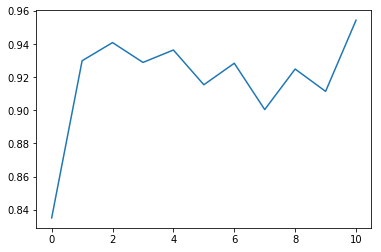

In [241]:
# allGBfactors = np.array([GBfactor1,GBfactor2,GBfactor3,GBfactor4,GBfactor5,GBfactor6,GBfactor7,GBfactor8,GBfactor9,GBfactor10,GBfactor11\
#                         ])#,GBfactor12,GBfactor13,GBfactor14,GBfactor15,GBfactor16,GBfactor17,GBfactor18,GBfactor20])

# allGRfactors = np.array([GRfactor1,GRfactor2,GRfactor3,GRfactor4,GRfactor5,GRfactor6,GRfactor7,GRfactor8,GRfactor9,GRfactor10,GRfactor11\
#                         ])#,GRfactor12,GRfactor13,GRfactor14,GRfactor15,GRfactor16,GRfactor17,GRfactor18,GRfactor20])

# allJfactors = np.array([Jfactor1,Jfactor2,Jfactor3,Jfactor4,Jfactor5,Jfactor6,Jfactor7,Jfactor8,Jfactor9,Jfactor10,Jfactor11\
#                        ])#,Jfactor12,Jfactor13,Jfactor14,Jfactor15,Jfactor16,Jfactor17,Jfactor18,Jfactor20])

# allHfactors = np.array([Hfactor1,Hfactor2,Hfactor3,Hfactor4,Hfactor5,Hfactor6,Hfactor7,Hfactor8,Hfactor9,Hfactor10,Hfactor11\
#                        ])#,Hfactor12,Hfactor13,Hfactor14,Hfactor15,Hfactor16,Hfactor17,Hfactor18,Hfactor20])

# allKfactors = np.array([Kfactor1,Kfactor2,Kfactor3,Kfactor4,Kfactor5,Kfactor6,Kfactor7,Kfactor8,Kfactor9,Kfactor10,Kfactor11\
#                        ])#,Kfactor12,Kfactor13,Kfactor14,Kfactor15,Kfactor16,Kfactor17,Kfactor18,Kfactor20])

# bestGBfactor = np.mean(allGBfactors)
# bestGRfactor = np.mean(allGRfactors)
# bestJfactor = np.mean(allJfactors)
# bestHfactor = np.mean(allHfactors)
# bestKfactor = np.mean(allKfactors)

# print(allGBfactors)
# print(bestGBfactor)
# print(len(Av12))
# plt.plot(allGBfactors)
# plt.show()

In [496]:
GBfactor1, GRfactor1 = CalcFactors(Av1,Av1)
GBfactor2, GRfactor2 = CalcFactors(Av2,Av2)
GBfactor3, GRfactor3 = CalcFactors(Av3,Av3)
GBfactor4, GRfactor4 = CalcFactors(Av4,Av4)
GBfactor5, GRfactor5 = CalcFactors(Av5,Av5)
GBfactor6, GRfactor6 = CalcFactors(Av6,Av6)
GBfactor7, GRfactor7 = CalcFactors(Av7,Av7)
GBfactor8, GRfactor8 = CalcFactors(Av8,Av8)
GBfactor9, GRfactor9 = CalcFactors(Av9,Av9)
GBfactor10, GRfactor10 = CalcFactors(Av10,Av10)
GBfactor11, GRfactor11 = CalcFactors(Av11,Av11)
GBfactor12, GRfactor12 = CalcFactors(Av12,Av12)
GBfactor13, GRfactor13 = CalcFactors(Av13,Av13)

In [497]:
allGBfactors = np.array([GBfactor1,GBfactor2,GBfactor3,GBfactor4,GBfactor5,GBfactor6,GBfactor7,GBfactor8,GBfactor9,GBfactor10,GBfactor11\
               ,GBfactor12,GBfactor13])

allGRfactors = np.array([GRfactor1,GRfactor2,GRfactor3,GRfactor4,GRfactor5,GRfactor6,GRfactor7,GRfactor8,GRfactor9,GRfactor10,GRfactor11\
               ,GRfactor12,GRfactor13])

bestGBfactor2 = np.mean(allGBfactors)
bestGRfactor2 = np.mean(allGRfactors)

print(allGBfactors)

[0.841 0.801 0.847 0.859 0.934 0.92  0.943 0.947 0.893 0.912 0.906 0.915
 0.921]


In [36]:

# print('\n\nAV: 0.25 - 0.50')
# n = CheckError(Av2,1,1,1,1,1)
# print('\n\nAV: 0.50 - 0.75')
# n = CheckError(Av3,1,1,1,1,1)
# print('\n\nAV: 0.75 - 1.0')
# n = CheckError(Av4,1,1,1,1,1)
# print('\n\nAV: 1.0 - 1.25')
# n = CheckError(Av5,1,1,1,1,1)
# print('\n\nAV: 1.25 - 1.5')
# n = CheckError(Av6,1,1,1,1,1)
# print('\n\nAV: 1.5 - 1.75')
# n = CheckError(Av7,1,1,1,1,1)
# print('\n\nAV: 1.75 - 2.0')
# n = CheckError(Av8,1,1,1,1,1)
# print('\n\nAV: 2.0 - 2.25')
# n = CheckError(Av9,1,1,1,1,1)
# print('\n\nAV: 2.25 - 2.5')
# n = CheckError(Av10,1,1,1,1,1)
# print('\n\nAV: 2.5 - 2.75')
# n = CheckError(Av11,1,1,1,1,1)
# print('\n\nAV: 2.75 - 3.0')
# n = CheckError(Av12,1,1,1,1,1)
# print('\n\nAV: 3.0 - 3.25')
# n = CheckError(Av13,1,1,1,1,1)

In [36]:
####### FirstAv 0.0 - 1.0
wvl = [477,677,1250,1650,2170]

def CalcSingleFactor1(Av,GBfactor,GRfactor,Jfactor,Hfactor,Kfactor):

    GBcolors = []
    GRcolors = []
    Jcolors = []
    Hcolors = []
    Kcolors = []
    
    for i in range(len(Av)):
        FitColors = Av[i,0]
        StarColors = Av[i,1]
        GB = (FitColors[0]*GBfactor - StarColors[0])
        GR = (FitColors[1]*GRfactor - StarColors[1])
        J = (FitColors[2]*Jfactor - StarColors[2])
        H = (FitColors[3]*Hfactor - StarColors[3])
        K = (FitColors[4]*Kfactor - StarColors[4])
        GBcolors.append(GB)
        GRcolors.append(GR)
        Jcolors.append(J)
        Hcolors.append(H)
        Kcolors.append(K)

        GBcolor = (GB)
        GRcolor = (GR)
        Jcolor = (J)
        Hcolor = (H)
        Kcolor = (K)
        allColors = [GBcolor,GRcolor,Jcolor,Hcolor,Kcolor]
       
    GBmedian = np.median(GBcolors)
    GRmedian = np.median(GRcolors)
    Jmedian = np.median(Jcolors)
    Hmedian = np.median(Hcolors)
    Kmedian = np.median(Kcolors)
    allMedians = [GBmedian,GRmedian,Jmedian,Hmedian,Kmedian]

    return allMedians


def CalcFactors1(AvArray):
    array = []
    factors = np.arange(0,1.5,0.001)
    for i in range(len(factors)):
        medians = CalcSingleFactor1(AvArray,factors[i],1,1,1,1)
        array.append(medians[0])
    GBfactor = []
    for j in range(len(array)):
        if(array[j] >= 0-.001 and array[j] <= 0+.001):
            minVal = array[j]
            indexValue = array.index(minVal)
            GBfactor.append(factors[indexValue])
    GBfactor = np.mean(GBfactor)
#         else:
#             GBfactor = 'Nothing'

    array = []
    for i in range(len(factors)):
        medians = CalcSingleFactor1(AvArray,1,factors[i],1,1,1)
        array.append(medians[1])
    GRfactor = []
    for j in range(len(array)):
        if(array[j] >= 0-.001 and array[j] <= 0+.001):
            minVal = array[j]
            indexValue = array.index(minVal)
            GRfactor.append(factors[indexValue])
    GRfactor = np.mean(GRfactor)    
    
    array = []
    for i in range(len(factors)):
        medians = CalcSingleFactor1(AvArray,1,1,factors[i],1,1)
        array.append(medians[2])
    Jfactor = []
    for j in range(len(array)):
        if(array[j] >= 0-.002 and array[j] <= 0+.002):
            minVal = array[j]
            indexValue = array.index(minVal)
            Jfactor.append(factors[indexValue])
    Jfactor = np.mean(Jfactor)    


    array = []
    for i in range(len(factors)):
        medians = CalcSingleFactor1(AvArray,1,1,1,factors[i],1)
        array.append(medians[3])
    Hfactor = []
    for j in range(len(array)):
        if(array[j] >= 0-.002 and array[j] <= 0+.002):
            minVal = array[j]
            indexValue = array.index(minVal)
            Hfactor.append(factors[indexValue])
    Hfactor = np.mean(Hfactor)    
    
    array = []
    for i in range(len(factors)):
        medians = CalcSingleFactor1(AvArray,1,1,1,1,factors[i])
        array.append(medians[4])
    Kfactor = []
    for j in range(len(array)):
        if(array[j] >= 0-.0025 and array[j] <= 0+.0025):
            minVal = array[j]
            indexValue = array.index(minVal)
            Kfactor.append(factors[indexValue])
    Kfactor = np.mean(Kfactor)    

    return GBfactor, GRfactor, Jfactor, Hfactor, Kfactor

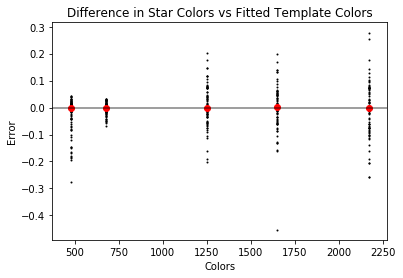


Median GB Error: -0.00020719801390606252
Median GR Error: 0.00018277338692440637
Median J Error: 4.2360262422214134e-06
Median H Error: 0.0004373214724362473
Median K Error: -0.0006444281075035363
0.9359999999999999 1.0385 1.046 1.022 1.0274999999999999
3


In [107]:
GBfactorz, GRfactorz, Jfactorz, Hfactorz, Kfactorz = CalcFactors1(Av6)
# print(GBfactorz,'\n',GRfactorz)
# print(GBfactor1)
n = CheckError(Av6,GBfactorz,GRfactorz,Jfactorz,Hfactorz,Kfactorz)
print(GBfactorz, GRfactorz, Jfactorz, Hfactorz, Kfactorz)
print(len(Av19))

In [246]:

ID = np.zeros(110)
start = time.time()
for i in range(len(ID)):
    n = np.random.randint(0,len(cornerBands))
    ID[i] = int(n)
#print(ID)
end = time.time()

n = int(ID[0])
print(n)
extBands = cornerBands[n]

636


In [247]:
# FOR STARS IN THE CORNER OF THE REGION OF THE CLOUD
all_chi_1 = []
all_Av_1 = []
all_colors_1 = []
start = time.time()
saveIndex = [2008]
br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))
Temps = br['Temps']
for loop in range(len(ID)):
    #n = np.random.randint(0,len(cornerBands))
    #n = 1781
    n = int(ID[loop])
    ApplyFactors = True

    extBands = cornerBands[n]
    MagUncert = []

    starGaiaFlux = cornerGaiaFluxs[n]
    starGaiaFlux_er = cornerGaiaFlux_ers[n]
    TmassError = cornerTmassErrors[n]

    starSNR = starGaiaFlux[0]/starGaiaFlux_er[0]

    for i in range(len(starGaiaFlux)):
        flux = starGaiaFlux[i]
        flux_er = starGaiaFlux_er[i]
        if(i == 0):
            Mag_er = MagError(flux,flux_er,0.004)
            #Mag_er = MagError(flux,flux_er,0.01)
            MagUncert.append(Mag_er)
        else:
            Mag_er = MagError(flux,flux_er,0.004)
            #Mag_er = MagError(flux,flux_er,0.03)
            MagUncert.append(Mag_er)
    MagUncert = np.array(MagUncert)
    MagUncert = np.append(MagUncert, TmassError)
    MagUncert = MagUncert[~np.isnan(MagUncert)]

    

    GKvals = []
    AvChi = []
    fits = []
    allChi2Vals = []
    RedChi2List = []
    QuadErrors = []

    AV_list = np.array(br['Av'])
    for i in range(len(AV_list)):

        curAv = Temps[AV_list[i]]
        colors = np.array(curAv['Colors'])
        errors = np.array(curAv['Errors'])
        if(ApplyFactors == True):
            colors[:,0] = colors[:,0]*bestGBfactor
            colors[:,1] = colors[:,1]*bestGRfactor
            colors[:,2] = colors[:,2]*bestJfactor
            colors[:,3] = colors[:,3]*bestHfactor
            colors[:,4] = colors[:,4]*bestKfactor

        Chi2 = []

        fit, chi, GKval, chi_array, Quad = StarFit(extBands,colors,MagUncert,errors)

        AvChi.append(chi)
        GKvals.append(GKval)
        fits.append(fit)
        allChi2Vals.append(chi)
        #RedChi2List.append(chi_array)
        #QuadErrors.append(Quad)
    allChi2Vals = np.array(allChi2Vals)
    #RedChi2List = np.array(RedChi2List)
    minVal = np.min(AvChi)
    indexValue = AvChi.index(minVal)
    extinction = AV_list[indexValue]
    all_Av_1.append(extinction)
    all_chi_1.append(allChi2Vals[indexValue])
    all_colors_1.append(GKvals[indexValue])
#     for i in range(len(AvChi)):
#         if(AvChi[i] == np.min(AvChi)):
#             all_Av_2.append(AV_list[i])
#             ext = AV_list[i]
#             #mags = Temps[AV_list[i]]
#             #chi_val = AvChi[i]
#             all_chi_2.append(allChi2Vals[i])
#             GK_val = GKvals[i]
# #             bestfit = fits[i]
#             index = i
#             AllChisGK = RedChi2List[i]
#             quadError = QuadErrors[i]
end = time.time()
print('Total Time:',end-start)
#print(all_Av,all_chi)

KeyboardInterrupt: 

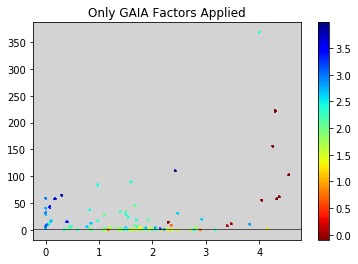

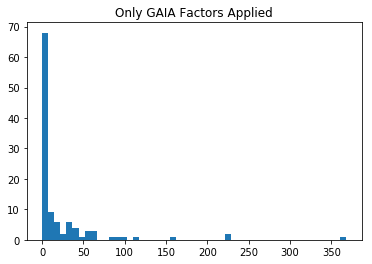

Average Reduced X^2: 22.67831479269151
Median Reduced X^2: 3.7707302753464313


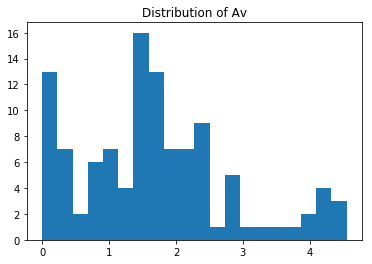

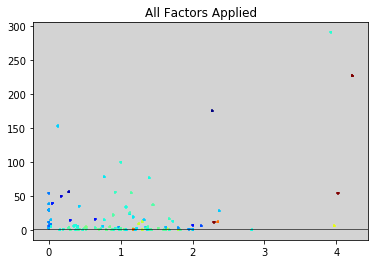

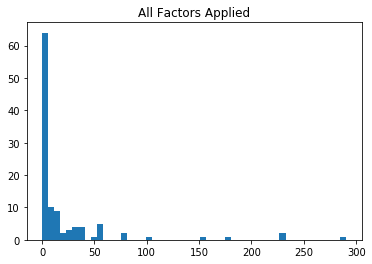

Average Reduced X^2: 21.58430083372187
Median Reduced X^2: 4.017908743897147


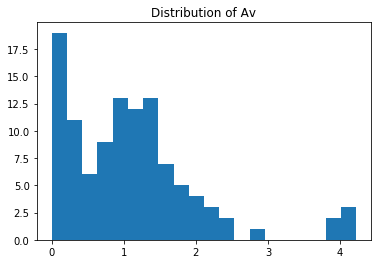

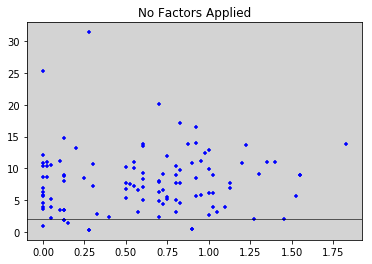

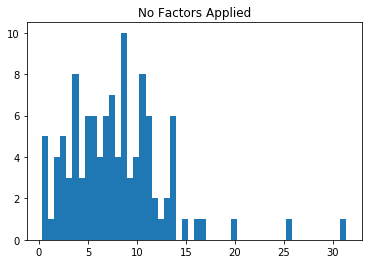

Average Reduced X^2: 7.886006213144961
Median Reduced X^2: 7.638371480687349


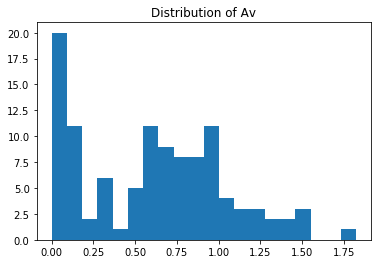

In [365]:
# #   ONLY GAIA FACTORS APPLIED TO TEMPLATES
fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av,all_chi,s=10.0,marker='+',c=all_colors)
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('Only GAIA Factors Applied')
plt.colorbar()
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi,50)
plt.title('Only GAIA Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi))
print('Median Reduced X^2:',np.median(all_chi))

plt.hist(all_Av,20)
plt.title('Distribution of Av')
plt.show()

#   WITH ALL FACTORS APPLIED TO TEMPLATES

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av_1,all_chi_1,s=10.0,marker='+',c=all_colors_1)
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('All Factors Applied')
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi_1,50)
plt.title('All Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi_1))
print('Median Reduced X^2:',np.median(all_chi_1))

plt.hist(all_Av_1,20)
plt.title('Distribution of Av')
plt.show()

#   WITH NO FACTORS APPLIED TO TEMPLATES

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av_2,all_chi_2,s=10.0,marker='+',c='b')
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('No Factors Applied')
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi_2,50)
plt.title('No Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi_2))
print('Median Reduced X^2:',np.median(all_chi_2))

plt.hist(all_Av_2,20)
plt.title('Distribution of Av')
plt.show()

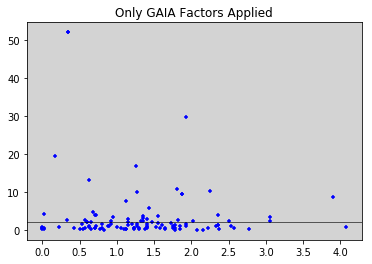

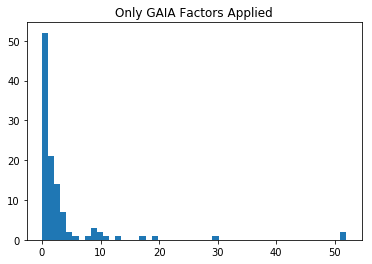

Average Reduced X^2: 3.465364966067746
Median Reduced X^2: 1.1158935746157448


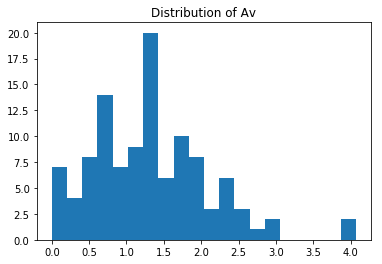

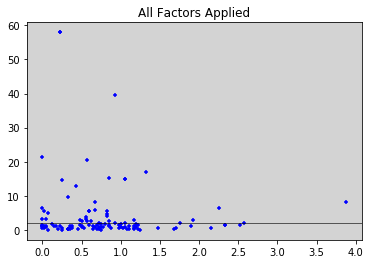

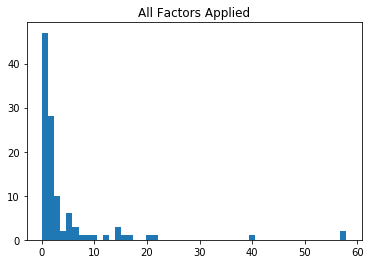

Average Reduced X^2: 4.298977124703
Median Reduced X^2: 1.354571334879075


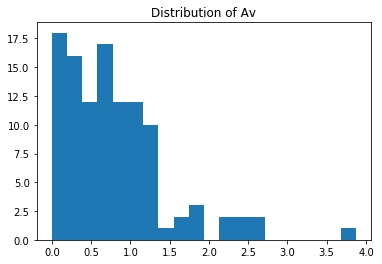

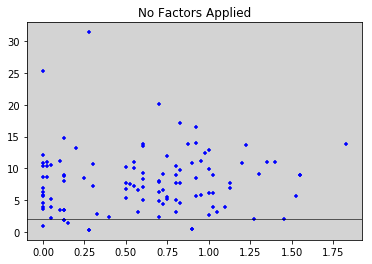

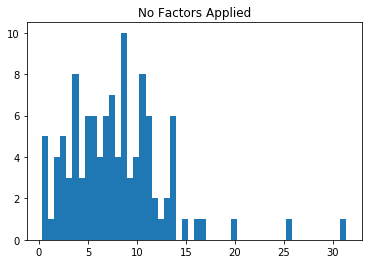

Average Reduced X^2: 7.886006213144961
Median Reduced X^2: 7.638371480687349


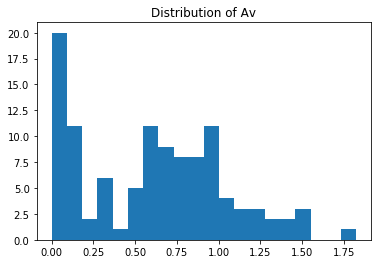

In [279]:
# #   ONLY GAIA FACTORS APPLIED TO TEMPLATES
fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av,all_chi,s=10.0,marker='+',c=all_colors)
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('Only GAIA Factors Applied')
plt.colorbar()
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi,50)
plt.title('Only GAIA Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi))
print('Median Reduced X^2:',np.median(all_chi))

plt.hist(all_Av,20)
plt.title('Distribution of Av')
plt.show()

#   WITH ALL FACTORS APPLIED TO TEMPLATES

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av_1,all_chi_1,s=10.0,marker='+',c=all_colors_1)
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('All Factors Applied')
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi_1,50)
plt.title('All Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi_1))
print('Median Reduced X^2:',np.median(all_chi_1))

plt.hist(all_Av_1,20)
plt.title('Distribution of Av')
plt.show()

#   WITH NO FACTORS APPLIED TO TEMPLATES

fig, ax = plt.subplots()
ax.set_facecolor('lightgray')
plt.scatter(all_Av_2,all_chi_2,s=10.0,marker='+',c='b')
plt.axhline(2.0,linewidth=1.0,alpha=0.6,c='k')
plt.title('No Factors Applied')
#plt.ylim(-3,80)
plt.show()

plt.hist(all_chi_2,50)
plt.title('No Factors Applied')
#plt.xlim(0,20)
plt.show()
print('Average Reduced X^2:',np.mean(all_chi_2))
print('Median Reduced X^2:',np.median(all_chi_2))

plt.hist(all_Av_2,20)
plt.title('Distribution of Av')
plt.show()

In [48]:
# allFactors = {}
# allFactors['GBfactor'] = bestGBfactor
# allFactors['GRfactor'] = bestGRfactor
# allFactors['Jfactor'] = bestJfactor
# allFactors['Hfactor'] = bestHfactor
# allFactors['Kfactor'] = bestKfactor

# with open('allFactors.pickle', 'wb') as handle:
#     pickle.dump(allFactors, handle, protocol=pickle.HIGHEST_PROTOCOL)

Factors = pickle.load(open('allFactors.pickle', 'rb'))

print(Factors['GBfactor'])

bestGBfactor = Factors['GBfactor']
bestGRfactor = Factors['GRfactor']
bestJfactor = Factors['Jfactor']
bestHfactor = Factors['Hfactor']
bestKfactor = Factors['Kfactor']

0.9188181818181819


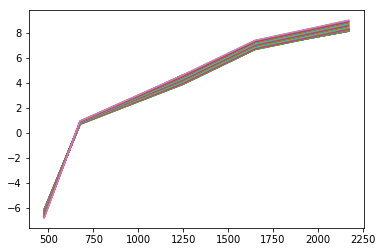

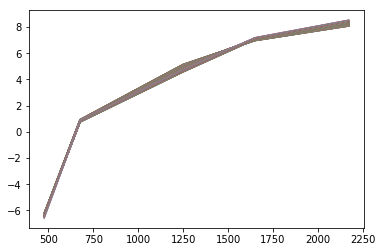

In [26]:
br = pickle.load(open('MainSequence_Av_CCM_Rv_4.1.pickle', 'rb'))


Temps = br['Temps']

curAv = Temps[19]
colors = np.array(curAv['Colors'])
for i in range(len(colors)):
    plt.plot(wvl,colors[i])
plt.show()

br = pickle.load(open('MainSequence_Av.pickle', 'rb'))

Temps = br['Temps']

curAv = Temps[19]
colors = np.array(curAv['Colors'])
for i in range(len(colors)):
    plt.plot(wvl,colors[i])
plt.show()